# Initialisation

## Imports

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

require(ez)
require(dplyr)
require(fitdistrplus)
require(lme4)
require(multcomp) # for glht
require(lsmeans) # for lsm
require(car)
library(ARTool)
library(reshape2)

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ez

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: dplyr

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required packa

In [3]:
# plot inline
%matplotlib inline

from IPython.core.display import display

# import librarires
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys

from scipy import stats 

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pandas.api.types import CategoricalDtype

from functools import partial, update_wrapper

from pivottablejs import pivot_ui

## Seaborn Setup

In [4]:
####################
### Basic Setups ###
####################

enable_saving_figures = True
def save_figure(g, width, height, path):
    g.set(xlabel='')
    g.set(ylabel='')
    g.fig.set_size_inches(width, height)
    if enable_saving_figures:
        g.fig.savefig(path, format='eps', dpi=1200, transparent=True)

# pd.set_option('display.notebook_repr_html', True)
# pd.set_option('display.max_columns', 50)

# set seaborn styles in general
sns.set()
sns.set_style('whitegrid', {'legend.frameon':True})
# sns.set_context('paper', rc={'font.size': 7, 
#                             'figure.titlesize': 'medium',
#                             'figure.titleweight': 700,
#                             'xtick.labelsize': 'small',
#                             'ytick.labelsize': 'small',
#                             'axes.labelsize': 'small',
#                             'legend.fontsize': 'small',
#                             'lines.linewidth': 0.5})

height = 2.0 * 4
width = 3.5 * 4

fig_width_pt = 243.98238  # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (math.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

sns.set_context('paper', rc={'font.size': 24, 
                            'figure.titlesize': 'medium',
                            'figure.titleweight': 700,
                            'xtick.labelsize': 'small',
                            'ytick.labelsize': 'small',
                            'axes.labelsize': 'small',
                            'legend.fontsize': 'small',
                            'lines.linewidth': 2,
                            'figure.figsize':fig_size
                            })




sns.set_palette(sns.xkcd_palette(['grey']) + sns.color_palette('colorblind', 3))

## Helper Functions

In [5]:
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func


def explore(dv, functions):
    for function, output in functions.items():
        output.clear_output()
        with output:
            function(dv)


def explore_functions(columns, exploratory_functions):
    dv = widgets.Dropdown(
        options=list(columns),
        description='Dependent Variable:',
    )

    tab = widgets.Tab()
    outputs = []

    for _ in exploratory_functions:
        outputs.append(widgets.Output())

    tab.children = outputs

    for i, f in enumerate(exploratory_functions):
        tab.set_title(i, f.__name__)

    ui = widgets.VBox([dv, tab])

    functions = dict(zip(exploratory_functions, outputs))

    out = widgets.interactive_output(
        explore, {'dv': dv, 'functions': fixed(functions)})

    display(ui, out)


def outlier(df, column):
    return ~(np.abs(df[column] - df[column].mean()) <= (3 * df[column].std()))


def fetch_questionnaire(questionnaire_id):
    base = 'https://docs.google.com/spreadsheets/d/<FILE_ID>/gviz/tq?tqx=out:csv'
    return pd.read_csv(base.replace('<FILE_ID>', questionnaire_id))


def block_dv_plot(df, dv):
    sns.factorplot(x='block',
                   y=dv,
                   hue='condition',
                   dodge=True,
                   data=df, size=height, aspect=width / height)
    plt.show()


def block_dv_analysis(df, dv):
    %R - i df - i dv twoWayAnova(df, dv)


def dv_plot(df, dv):
    sns.factorplot(x='condition',
                   y=dv,
                   data=df,
                   kind='bar',
                   size=height, aspect=width / height)
    plt.show()


def dv_analysis(df, dv):
    %R - i df - i dv oneWayAnova(df, dv)


def last_block(df, dv):
    df = df[df['block'] == max(df['block'])]
    %R - i df - i dv oneWayAnova(df, dv)

In [6]:
%%R 
oneWayAnova <- function(df, dv) {

    df$condition = factor(df$condition)
    df$participant = factor(df$participant)
    
    normality(df,dv)

    m <- eval(
        substitute(
          ezANOVA(data = df, 
                  wid = participant, 
                  dv = dv, 
                  between = condition,
                  return_aov=TRUE), 
        list(dv = dv)))
    
    print(m)
#     plot(m$aov)
    TukeyHSD(m$aov)
    ezDesign(df, condition, dv)
}

twoWayAnova <- function(df, dv) {

    df$block = factor(df$block)
    df$condition = factor(df$condition)
    df$participant = factor(df$participant)

    interaction.plot(df$block, df$condition, df[,dv])
    normality(df,dv)

    m <- eval(
        substitute(
          ezANOVA(data = df, 
                  wid = participant, 
                  dv = dv, 
                  between = condition,
                  within=block,
                  return_aov=TRUE), 
        list(dv = dv)))
    print(m)
#     print(summary(m$aov))
}

normality <- function(df, dv) {
    qqnorm(df[,dv])
    qqline(df[,dv])    
}

# Data Loading + Cleaning

In [10]:
json = pd.read_json('data.json')
json.columns

Index(['activatedWtihGuidance', 'area', 'attempts', 'block', 'block_type',
       'checkedLinearMenu', 'checkedShortcutInterface', 'condition',
       'dismissedLinearMenu', 'dismissedShortcutInterface',
       'erroredLinearMenu', 'errors', 'eventualActivationMethod',
       'finalReferenceTime', 'finalTaskTime', 'frequency', 'grouped',
       'hasKeyError', 'isSuccessfulRecall', 'key', 'numAttempts',
       'participant', 'rawLogs', 'referenceTask', 'shortcut', 'title',
       'totalFinalTaskTime', 'totalReferenceTime', 'totalTaskTime',
       'totalTime', 'trial'],
      dtype='object')

In [11]:
qualitative = fetch_questionnaire('18pwOH1C1Ocw0VwjzYf7NfIfoRtSxLi_1WRn3zHuNatU')
qualitative = qualitative[~qualitative['Condition'].isnull()]

In [12]:
del qualitative['Name']
qualitative.columns
qualitative['Condition'] = qualitative['Condition'].astype('category', ['Baseline', 'Feedback', 'FingerArc', 'FingerChord'], ordered=True)


In [13]:
subjective = qualitative[["ID", "Condition", 'Ease of Use', 'Ease of Learning the Technique',
       'Ease of Memorising Shortcuts', 'Hand Fatigue', 'Eye Fatigue',
       'Accuracy', 'Speed',
       'How likely you will use this technique in real life?',
       'Preference for Primary Posture', 'Preference for Secondary Posture',
       'Preference for Tertiary Posture', 'Preference for Quaternary Posture']]


subjective = pd.melt(subjective, id_vars=["ID", "Condition"], var_name="Var", value_name="Value")


In [14]:
# json['rawLogs'][0]

In [15]:
json['recall'] = json.isSuccessfulRecall.map(int)
json['condition'] = json['condition'].astype('category', ['Baseline', 'Feedback', 'FingerArc', 'FingerChord'], ordered=True)

del json['rawLogs']
del json['attempts']

In [16]:
def codeAttempt(row):
    if row['checkedLinearMenu']:
        return 'linear_menu'
    if row['checkedShortcutInterface']:
        return 'shortcut_interface'
    else:
        return 'expert'

In [17]:
training = json[json['block_type'] == 'training'].copy()
training['expert_use'] = training['recall']
training['no_errors'] = training['errors'] == 0


training['Condition'] = training['condition']
training['Grouped'] = training['grouped'].map(lambda x: 'Grouped' if x else 'Ungrouped').astype('category', ['Ungrouped', 'Grouped'])


training['selection_type'] = training.apply(codeAttempt, axis=1)
training['selection_type'] = training['selection_type'].astype('category', ['linear_menu', 'shortcut_interface', 'expert'], ordered=True)
training['Total Task Time'] = training['totalTaskTime']
training['one_error'] = training['errors'].astype(bool).astype(int)
training['expert_attempt'] = training['selection_type'] == 'expert'

training['before_distractor'] = training['block'] < 8
training['total_expert_use'] = training['expert_use'].cumsum()

training['total_expert_use'] = training.groupby(['participant', 'block'])['expert_use'].cumsum()
training['total_expert_use_command'] = training.groupby(['participant', 'shortcut'])['expert_use'].cumsum()

# training['percent_expert_use'] = training['total_expert_use'] / training.groupby(['participant', 'block'])['expert_use'].sum()
training['trial_total'] = training['block'] * training['trial']
training['used_linear_menu'] = training['selection_type'] == 'linear_menu'
training['expert_use_sum'] = training['expert_use'].copy()

del training['totalTime']

training['guided'] = training['condition'].map(lambda x: 'unguided' if x == 'Baseline' else 'guided')
#TODO: extract expert mode out
training['multiple_modes'] = training['checkedLinearMenu'].astype(int) + training['checkedShortcutInterface'].astype(int)

training['dismissedAny'] = (training['dismissedLinearMenu'] | training['dismissedShortcutInterface']).astype(int)

In [18]:
training.columns

Index(['activatedWtihGuidance', 'area', 'block', 'block_type',
       'checkedLinearMenu', 'checkedShortcutInterface', 'condition',
       'dismissedLinearMenu', 'dismissedShortcutInterface',
       'erroredLinearMenu', 'errors', 'eventualActivationMethod',
       'finalReferenceTime', 'finalTaskTime', 'frequency', 'grouped',
       'hasKeyError', 'isSuccessfulRecall', 'key', 'numAttempts',
       'participant', 'referenceTask', 'shortcut', 'title',
       'totalFinalTaskTime', 'totalReferenceTime', 'totalTaskTime', 'trial',
       'recall', 'expert_use', 'no_errors', 'Condition', 'Grouped',
       'selection_type', 'Total Task Time', 'one_error', 'expert_attempt',
       'before_distractor', 'total_expert_use', 'total_expert_use_command',
       'trial_total', 'used_linear_menu', 'expert_use_sum', 'guided',
       'multiple_modes', 'dismissedAny'],
      dtype='object')

In [19]:
training.to_csv('training.csv')

## Outliers

In [20]:
# training = training[~outlier(training, 'finalTaskTime')]
# training = training[~outlier(training, 'errors')]

In [21]:
test = json[json['block_type'] == 'test'].copy()


test['Grouped'] = test['grouped'].map(lambda x: 'Grouped' if x else 'Ungrouped').astype('category', ['Ungrouped', 'Grouped'])


## Grouping

In [22]:
training.columns

Index(['activatedWtihGuidance', 'area', 'block', 'block_type',
       'checkedLinearMenu', 'checkedShortcutInterface', 'condition',
       'dismissedLinearMenu', 'dismissedShortcutInterface',
       'erroredLinearMenu', 'errors', 'eventualActivationMethod',
       'finalReferenceTime', 'finalTaskTime', 'frequency', 'grouped',
       'hasKeyError', 'isSuccessfulRecall', 'key', 'numAttempts',
       'participant', 'referenceTask', 'shortcut', 'title',
       'totalFinalTaskTime', 'totalReferenceTime', 'totalTaskTime', 'trial',
       'recall', 'expert_use', 'no_errors', 'Condition', 'Grouped',
       'selection_type', 'Total Task Time', 'one_error', 'expert_attempt',
       'before_distractor', 'total_expert_use', 'total_expert_use_command',
       'trial_total', 'used_linear_menu', 'expert_use_sum', 'guided',
       'multiple_modes', 'dismissedAny'],
      dtype='object')

In [23]:
training['finalTaskTimeMedian'] = training['finalTaskTime'].copy()
training['finalReferenceTimeMedian'] = training['finalReferenceTime'].copy()

training['finalTaskTimeMean'] = training['finalTaskTime'].copy()
training['finalReferenceTimeMean'] = training['finalReferenceTime'].copy()

    

# def trial_expert_percent(x):
#     return x.sum() / len(training['trial'].unique())

training_quantitative_columns = {'errors' : 'mean', 
                                 'one_error' : 'mean',
                                 'expert_use' : 'mean', 
                                 'expert_attempt' : 'mean', 

                                 'expert_use_sum' : 'sum', 

#                                  'error_attempts' : error_attempts,
                                 'dismissedAny' : 'mean',
                                 'dismissedLinearMenu' : 'mean',
                                 'dismissedShortcutInterface' : 'mean',
                                 'totalTaskTime' : 'median', 
                                 'used_linear_menu' : 'mean',
                                 'Total Task Time' : 'median', 
                                 'finalTaskTimeMedian' : 'median', 
                                 'finalReferenceTimeMedian' : 'median', 
                                 'finalTaskTimeMean' : 'mean', 
                                 'finalReferenceTimeMean' : 'mean'}


training_grouped =  training.groupby(['condition', 'block', 'participant'], as_index=False).agg(training_quantitative_columns)
training_all =  training.groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)

training_selection_all =  training.groupby(['condition', 'participant', 'selection_type'], as_index=False).agg(training_quantitative_columns)
training_selection_blocked =  training.groupby(['condition', 'participant' , 'block', 'selection_type'], as_index=False).agg(training_quantitative_columns)
training_participant_block = training.groupby(['participant', 'block'], as_index=False).agg(training_quantitative_columns)

In [24]:
test['finalTaskTimeMedian'] = test['finalTaskTime'].copy()
test['finalReferenceTimeMedian'] = test['finalReferenceTime'].copy()
test['totalTimeMedian'] = test['totalTime'].copy()

test['finalTaskTimeMean'] = test['finalTaskTime'].copy()
test['finalReferenceTimeMean'] = test['finalReferenceTime'].copy()
test['totalTimeMean'] = test['totalTime'].copy()

test_quantitative_columns = {'recall' : 'sum',
                             'finalTaskTimeMedian' : 'median', 
                             'finalReferenceTimeMedian' : 'median', 
                             'finalTaskTimeMean' : 'mean', 
                             'finalReferenceTimeMean' : 'mean'
                            }
test_grouped =  test.groupby(['condition', 'block', 'participant'], as_index=False).agg(test_quantitative_columns)
test_all =  test.groupby(['condition', 'participant'], as_index=False).agg(test_quantitative_columns)

test_participant_block = training.groupby(['participant', 'block'], as_index=False).agg(test_quantitative_columns)

# Analysis

## Exploratory

### Design

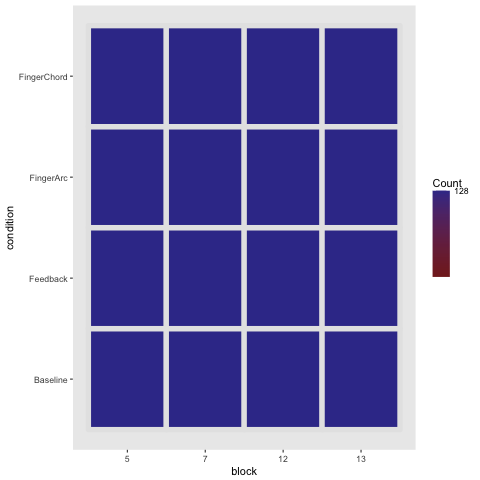

In [25]:
%%R -i test

ezDesign(test, block, condition)

In [26]:
%%R -i test

ezDesign(training, block, grouped, condition)


Error in ezDesign(training, block, grouped, condition) : 
  object 'training' not found


/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in ezDesign(training, block, grouped, condition) : 
  object 'training' not found

  warnings.warn(x, RRuntimeWarning)


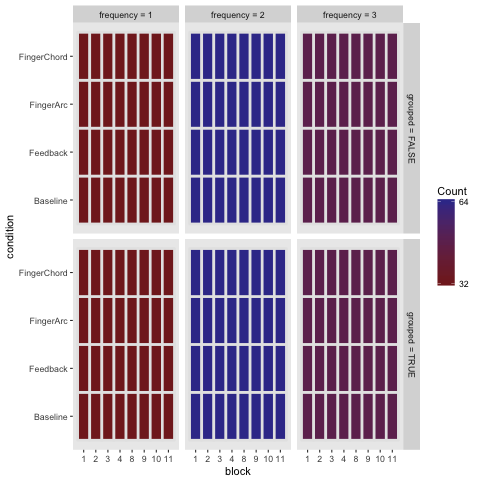

In [27]:
%%R -i training

ezDesign(training, block, condition, grouped, frequency)

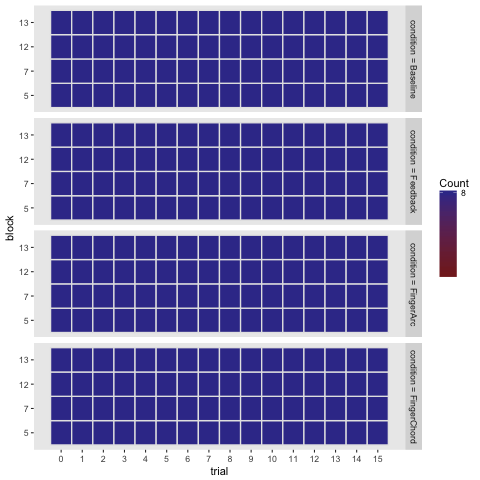

In [28]:
%%R -i test

ezDesign(test, trial, block, condition)

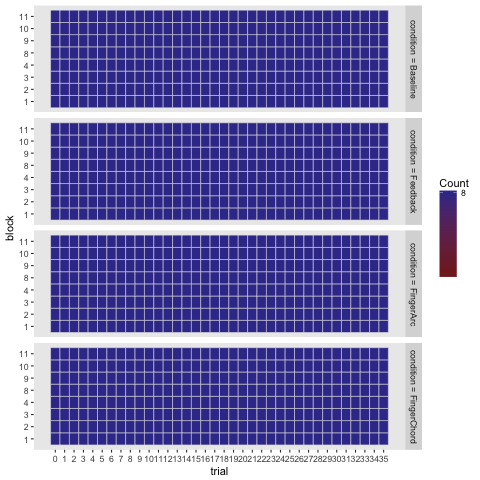

In [29]:
%%R -i training 
ezDesign(training, trial, block, condition)

### Explore

In [30]:
training['erroredLinearMenu'] = training['erroredLinearMenu'].map(int)

In [31]:
training[['erroredLinearMenu', 'condition']].groupby('condition').agg([np.mean, np.std])

erroredLinearMenu          
                         mean       std
condition                              
Baseline             0.007378  0.085599
Feedback             0.006076  0.077731
FingerArc            0.000434  0.020833
FingerChord          0.000868  0.029456

In [32]:
training[['erroredLinearMenu']].agg([np.mean, np.std])

,erroredLinearMenu
mean,0.003689
std,0.060630


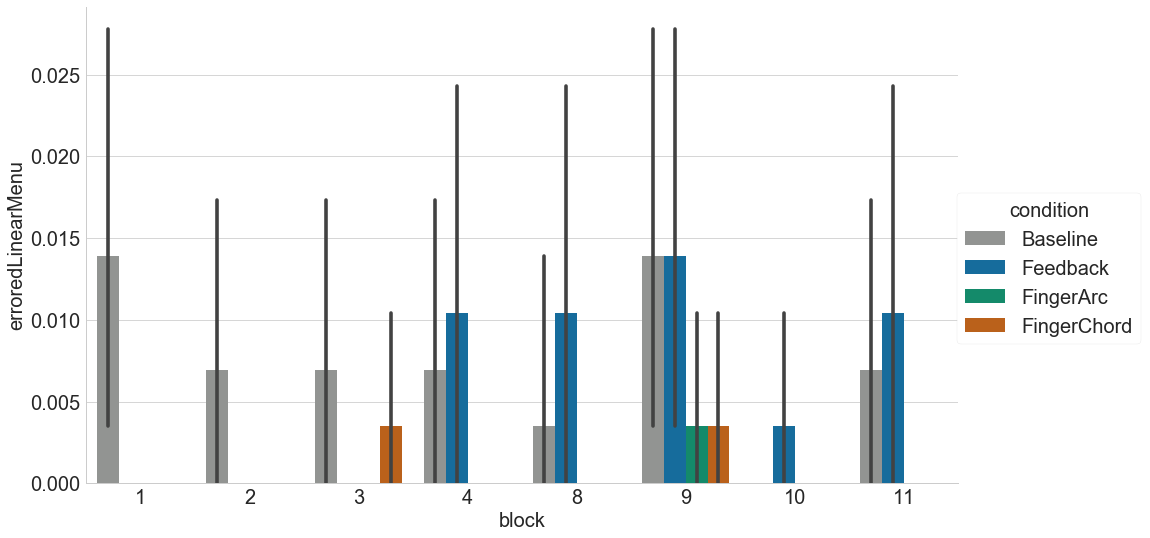

In [33]:
sns.factorplot(x='block', y="erroredLinearMenu", hue="condition",kind='bar', data=training, size=height, aspect=width/height)


In [34]:
shortcut_training = training.groupby(['participant', 'condition', 'grouped', 'shortcut'], as_index=False)
cumcount = shortcut_training.cumcount()

training['times_seen'] = cumcount + 1

shortcut_training = training[training['shortcut'] != ''].groupby(['participant', 'condition', 'grouped', 'shortcut'], as_index=False)

In [35]:
def find_first_and_last_uses(x):
#     'linear_menu', 'shortcut_interface', 'expert'
    x = x.set_index('times_seen')
    
    for index, row in x.iterrows():
        if row['selection_type'] == 'expert' and not 'first_expert' in x.columns:
            x['first_expert'] = index
            x['first_expert_time'] = row['totalTaskTime']
        elif row['selection_type'] == 'shortcut_interface':
            if not 'first_expert' in x.columns:
                x['first_shortcut_interface'] = index
                x['first_shortcut_interface_time'] = row['totalTaskTime']

            x['last_shortcut_interface'] = index
            x['last_shortcut_interface_time'] = row['totalTaskTime']
        else:
            x['last_linear_menu'] = index
            x['last_linear_menu_time'] = row['totalTaskTime']

    return x

df = shortcut_training.apply(find_first_and_last_uses).reset_index()
df['transition_length'] = df['last_linear_menu'] - df['first_expert']
df['transition_time_diff'] =  df['last_linear_menu_time'] - df['first_expert_time']
# df['transition_time_diff'] = df['']

t = df.groupby(['condition', 'participant', 'shortcut'], as_index=False).median()

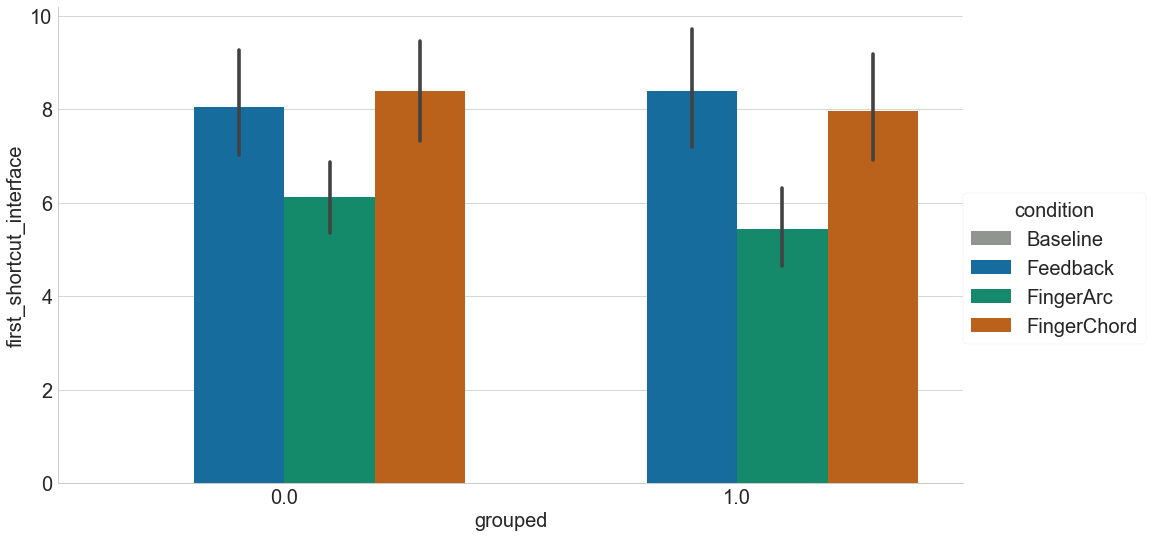

In [36]:
sns.factorplot(hue='condition', x='grouped', y='first_shortcut_interface', kind='bar', data=t, size=height, aspect=width/height)

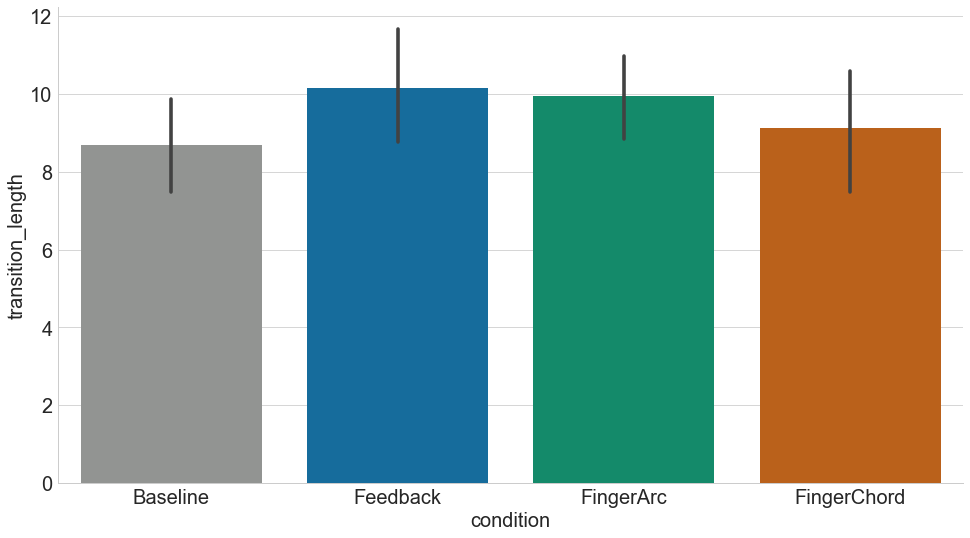

In [37]:
sns.factorplot(x='condition', y='transition_length', kind='bar', data=t, size=height, aspect=width/height)

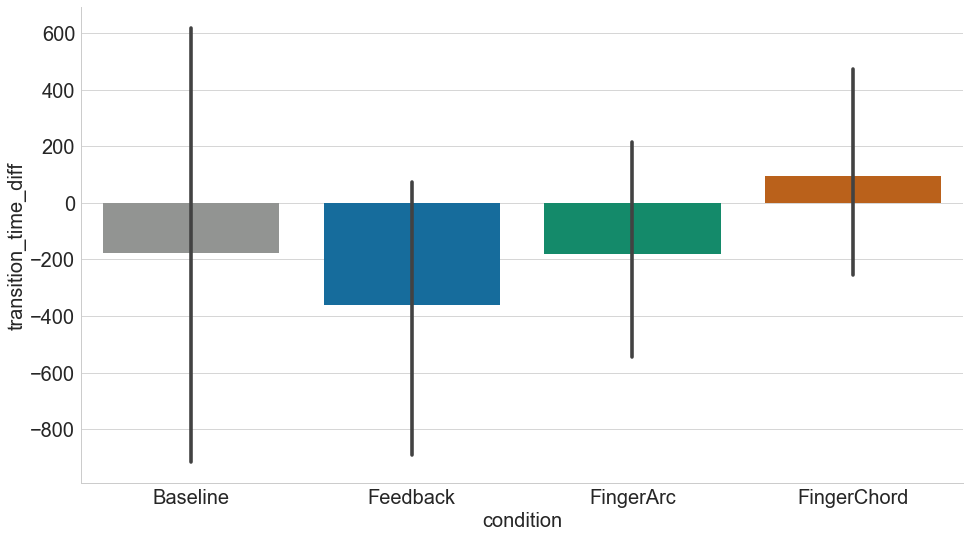

In [38]:
sns.factorplot(x='condition',  y='transition_time_diff', kind='bar', data=t, size=height, aspect=width/height)

In [39]:
#  # participants = [0, 8, 16, 24]
# participants = [8]
# participant = 2

# blue = sns.xkcd_rgb["blue"]
# for participant in participants:
#     shortcuts = training[training['participant'] == participant]['shortcut'].unique()
#     shortcut = shortcuts[0]

#     for shortcut in shortcuts:
#         fig, ax = plt.subplots()

#         # for participant, for shortcut

#         dff = training[(training['participant'] == participant) & (training['shortcut'] == shortcut)]

#         sns.pointplot(y='totalTaskTime', x='times_seen', data=dff, ax=ax, color=blue)
#         ax2 = ax.twinx()
#         sns.pointplot(y='expert_use', x='times_seen', data=dff, ax=ax2)

#         p = t[(t['participant'] == participant) & (t['shortcut'] == shortcut)]
        
#         if len(p) == 0:
#             print(participant, 'shortcut: ', shortcut)
#             print('none')
#             continue
#         # display(shortcut_training['participant'] == 0)
#         # display(shortcut_training['shortcut'] == 'p1')
#         print(p['novice_transition'].iloc[0])
#         print(p['expert_transition'].iloc[0])
#         ax.axvline(p['novice_transition'].iloc[0], linestyle='--')
#         ax.axvline(p['expert_transition'].iloc[0], linestyle='--')

In [40]:
# sns.pointplot(y='selection_type', x='times_seen', col='shortcut', col_wrap=3, data=training[training['participant'] == 0])
training[training['participant'] == 0]['times_seen']

0       1
1       1
2       2
3       1
4       1
5       2
6       1
7       1
8       1
9       1
10      3
11      1
12      2
13      1
14      2
15      1
16      1
17      1
18      2
19      1
20      2
21      2
22      3
23      3
24      2
25      1
26      1
27      2
28      2
29      2
       ..
290    22
291    23
292    15
293    23
294    24
295    15
296    22
297    15
298    15
299    15
300    16
301    15
302    15
303     8
304    23
305     8
306    16
307    15
308    16
309    16
310     8
311    24
312    24
313    23
314    16
315    16
316    24
317    16
318    16
319    16
Name: times_seen, Length: 288, dtype: int64

In [41]:
exploratory_functions = [wrapped_partial(block_dv_plot, training_grouped), wrapped_partial(block_dv_analysis, training_grouped), wrapped_partial(dv_plot, training_all), wrapped_partial(dv_analysis, training_all), wrapped_partial(last_block, training_grouped)]
explore_functions(training_quantitative_columns.keys(), exploratory_functions)

In [42]:
def factorplot(x, y, hue, col, row, data, kind):
    grouping = [c for c in [x, hue, col, row] if c]
    grouping.append('participant')
    df = data.groupby(grouping, as_index=False).agg(quantitative_columns)
    col_wrap = 2 if col and not row else None
    print(df.columns)
    sns.factorplot(x=x, 
                   y=y, 
                   col=col, 
                   hue=hue,
                   row=row, 
                   data=df, 
                   col_wrap=col_wrap,
                   kind=kind,
                   dodge=True,
                   size=height, aspect=width/height)
    plt.show()
kind=['point', 'bar', 'count', 'box', 'violin', 'strip']
quantitative_columns = training_quantitative_columns
grouping_factors= ['grouped', 'frequency', 'participant', 'condition', 'block', 'trial', None]
interact(factorplot, data=fixed(training), row=grouping_factors, col=grouping_factors, hue=grouping_factors, x=grouping_factors, y=quantitative_columns.keys(), kind=kind)
# sns.factorplot(x='block', y='errors', data=training)

<function __main__.factorplot>

In [43]:
exploratory_functions = [wrapped_partial(block_dv_plot, test_grouped), wrapped_partial(block_dv_analysis, test_grouped), wrapped_partial(dv_plot, test_all), wrapped_partial(dv_analysis, test_all), wrapped_partial(last_block, test_grouped)]
explore_functions(test_quantitative_columns.keys(), exploratory_functions)

### Condition X Block X Grouped X Frequency

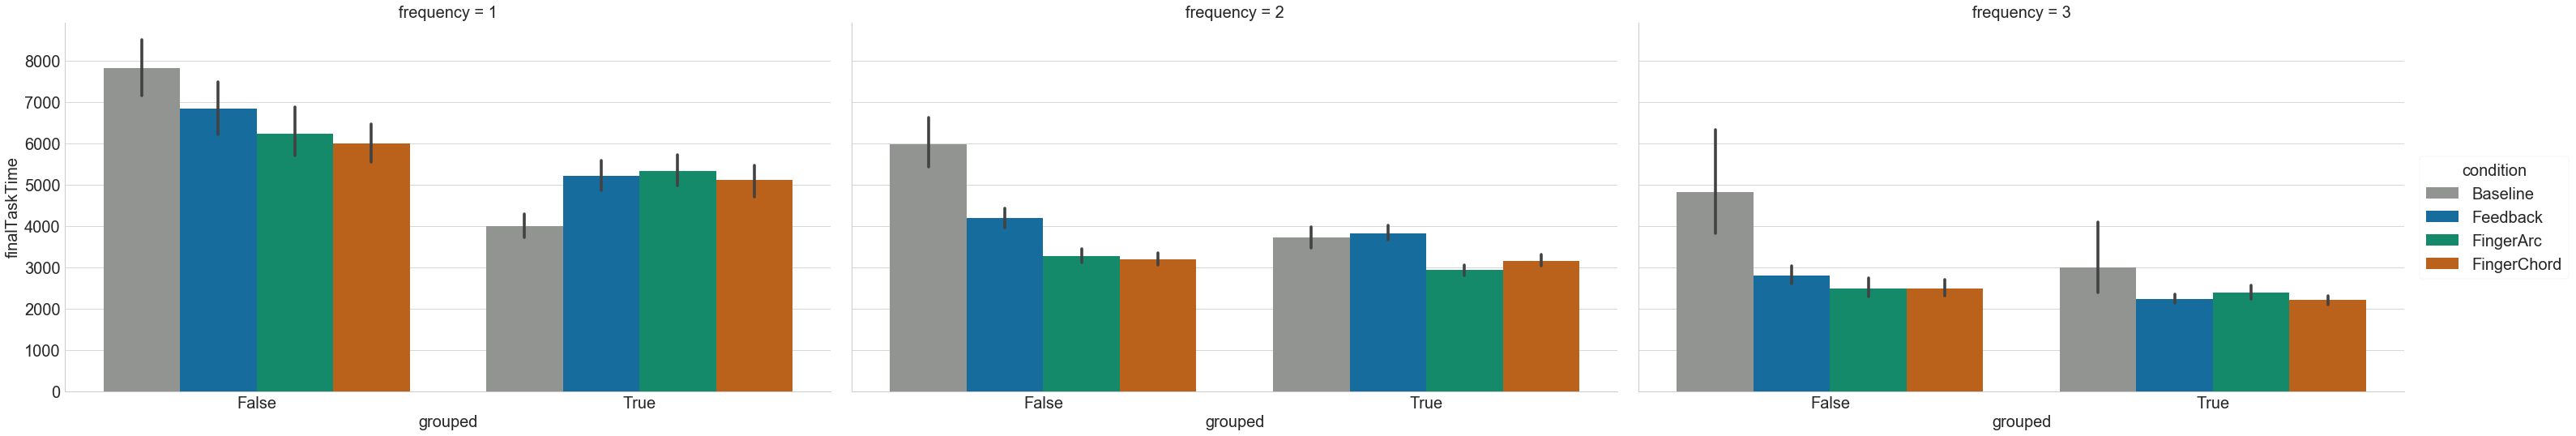

In [44]:
sns.factorplot(x='grouped', y="finalTaskTime", hue="condition", col='frequency', kind='bar', data=training, size=height, aspect=width/height)


In [45]:
%%R -i training

training$block = factor(training$block)
training$condition = factor(training$condition)
training$participant = factor(training$participant)
training$grouped = factor(training$grouped)
training$frequency = factor(training$frequency)


ezANOVA(data = training, 
          wid = participant, 
          dv = finalTaskTimeMedian, 
          between = condition,
          within=c(frequency, grouped),
          return_aov=TRUE)

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

  warnings.warn(x, RRuntimeWarning)


$ANOVA
                       Effect DFn DFd          F            p p<.05        ges
2                   condition   3  28   2.982767 4.816189e-02     * 0.14465119
3                   frequency   2  56 109.172436 4.752838e-20     * 0.54211947
5                     grouped   1  28  71.399097 3.448839e-09     * 0.18221806
4         condition:frequency   6  56   2.113410 6.594315e-02       0.06433611
6           condition:grouped   3  28  16.737082 2.008901e-06     * 0.13546976
7           frequency:grouped   2  56  17.587140 1.182603e-06     * 0.04772364
8 condition:frequency:grouped   6  56   1.255309 2.928296e-01       0.01061724

$`Mauchly's Test for Sphericity`
                       Effect         W           p p<.05
3                   frequency 0.8537304 0.118257959      
4         condition:frequency 0.8537304 0.118257959      
7           frequency:grouped 0.6331527 0.002091049     *
8 condition:frequency:grouped 0.6331527 0.002091049     *

$`Sphericity Corrections`
          

### Qualitative

In [46]:
qualitative['use'] = qualitative['Ease of Use']
qualitative['learning'] = qualitative['Ease of Learning the Technique']
qualitative['memorising'] = qualitative['Ease of Memorising Shortcuts']
qualitative['hand'] = qualitative['Hand Fatigue']
qualitative['eye'] = qualitative['Eye Fatigue']
qualitative['likely'] = qualitative['How likely you will use this technique in real life?']
qualitative['primary'] = qualitative['Preference for Primary Posture']
qualitative['secondary'] = qualitative['Preference for Secondary Posture']
qualitative['tertiary'] = qualitative['Preference for Tertiary Posture']
qualitative['quaternary'] = qualitative['Preference for Quaternary Posture']

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Anova Table (Type III tests) 
Model: No Repeated Measures (lm)
Response: art(use)

            Df Df.res F value  Pr(>F)  
1 Condition  3     28  3.1164 0.04195 *
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 

	Shapiro-Wilk normality test

data:  residuals(m)
W = 0.91005, p-value = 0.01127

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Anova Table (Type III tests) 
Model: No Repeated Measures (lm)
Response: art(learning)

            Df Df.res F value   Pr(>F)  
1 Condition  3     28  2.9968 0.047469 *
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 

	Shapiro-Wilk normality test

data:  residuals(m)
W = 0.79043, p-value = 2.708e-05

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Anova Table (Type III tests) 
Model: No Repeated Measures (lm)
Response: art(primary)

            Df Df.res F value   Pr(>F)  
1 Condition  3     28  4.5439 0.

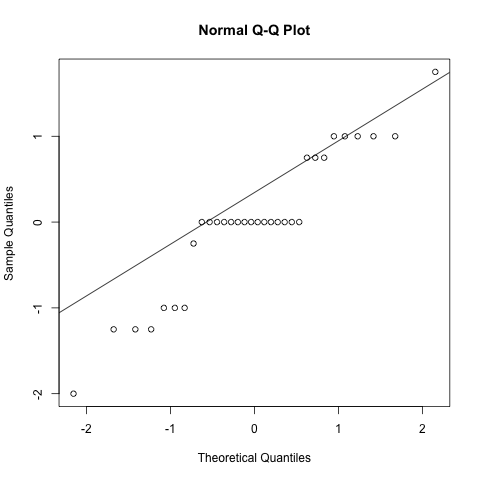

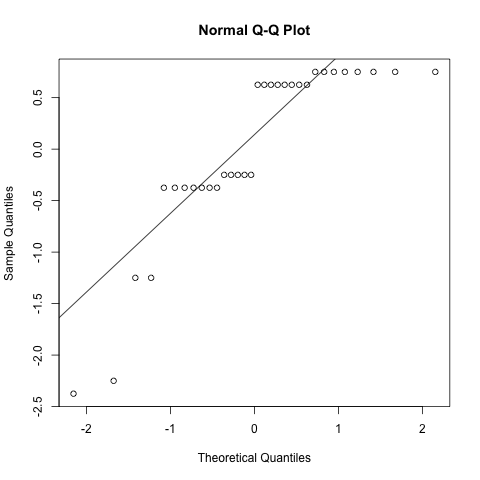

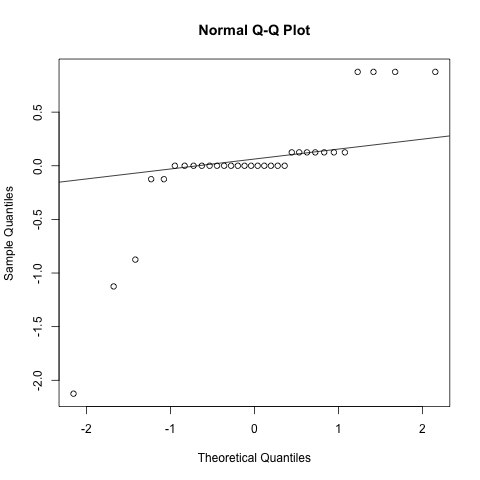

In [47]:
%%R -i qualitative

qualitative$Condition = factor(qualitative$Condition)

# # print(kruskal.test(Accuracy ~ Condition, data=qualitative))
# # print(kruskal.test(Speed ~ Condition, data=qualitative))
# print(kruskal.test(use ~ Condition, data=qualitative))
# print(kruskal.test(learning ~ Condition, data=qualitative))
# # print(kruskal.test(memorising ~ Condition, data=qualitative))
# # print(kruskal.test(hand ~ Condition, data=qualitative))
# # print(kruskal.test(eye ~ Condition, data=qualitative))
# # print(kruskal.test(likely ~ Condition, data=qualitative))
# print(kruskal.test(primary ~ Condition, data=qualitative))
# # print(kruskal.test(secondary ~ Condition, data=qualitative))
# # print(kruskal.test(tertiary ~ Condition, data=qualitative))
# # print(kruskal.test(quaternary ~ Condition, data=qualitative))

# pairwise.wilcox.test(qualitative$primary, qualitative$Condition, p.adj="holm", exact=F)


# print(anova(art(Accuracy ~ Condition, data=qualitative)))
# print(anova(art(Speed ~ Condition, data=qualitative)))
m <- art(use ~ Condition, data=qualitative)
print(anova(m))
print(shapiro.test(residuals(m))) # normality?
qqnorm(residuals(m)); qqline(residuals(m)) # seems to conform

m <- art(learning ~ Condition, data=qualitative)
print(anova(m))
print(shapiro.test(residuals(m))) # normality?
qqnorm(residuals(m)); qqline(residuals(m)) # seems to conform

# print(anova(art(memorising ~ Condition, data=qualitative)))
# print(anova(art(hand ~ Condition, data=qualitative)))
# print(anova(art(eye ~ Condition, data=qualitative)))
# print(anova(art(likely ~ Condition, data=qualitative)))
m <- art(primary ~ Condition, data=qualitative)
print(anova(m))
print(shapiro.test(residuals(m))) # normality?
qqnorm(residuals(m)); qqline(residuals(m)) # seems to conform

# print(anova(art(secondary ~ Condition, data=qualitative)))
# print(anova(art(tertiary ~ Condition, data=qualitative)))
# print(anova(art(quaternary ~ Condition, data=qualitative)))


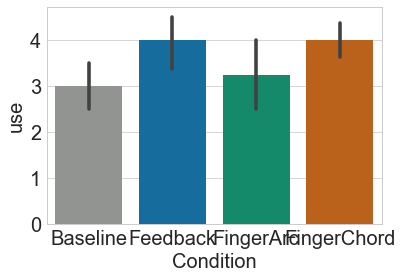

In [48]:
sns.barplot(x="Condition", y="use", data=qualitative)

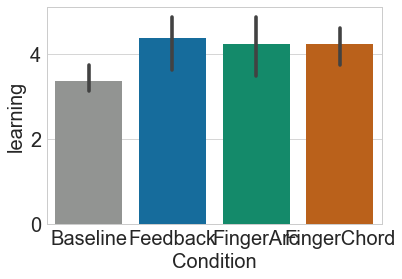

In [49]:
sns.barplot(x="Condition", y="learning", data=qualitative)

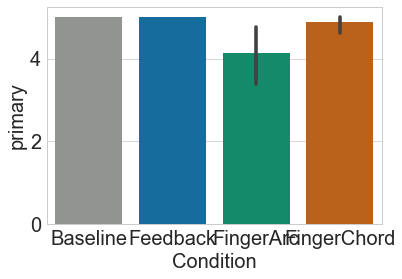

In [50]:
sns.barplot(x="Condition", y="primary", data=qualitative)

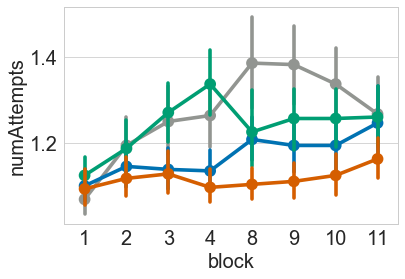

In [51]:
g = sns.pointplot(x='block', y='numAttempts', hue='condition', data=training, legend=False)
g.legend_.remove()


### Test

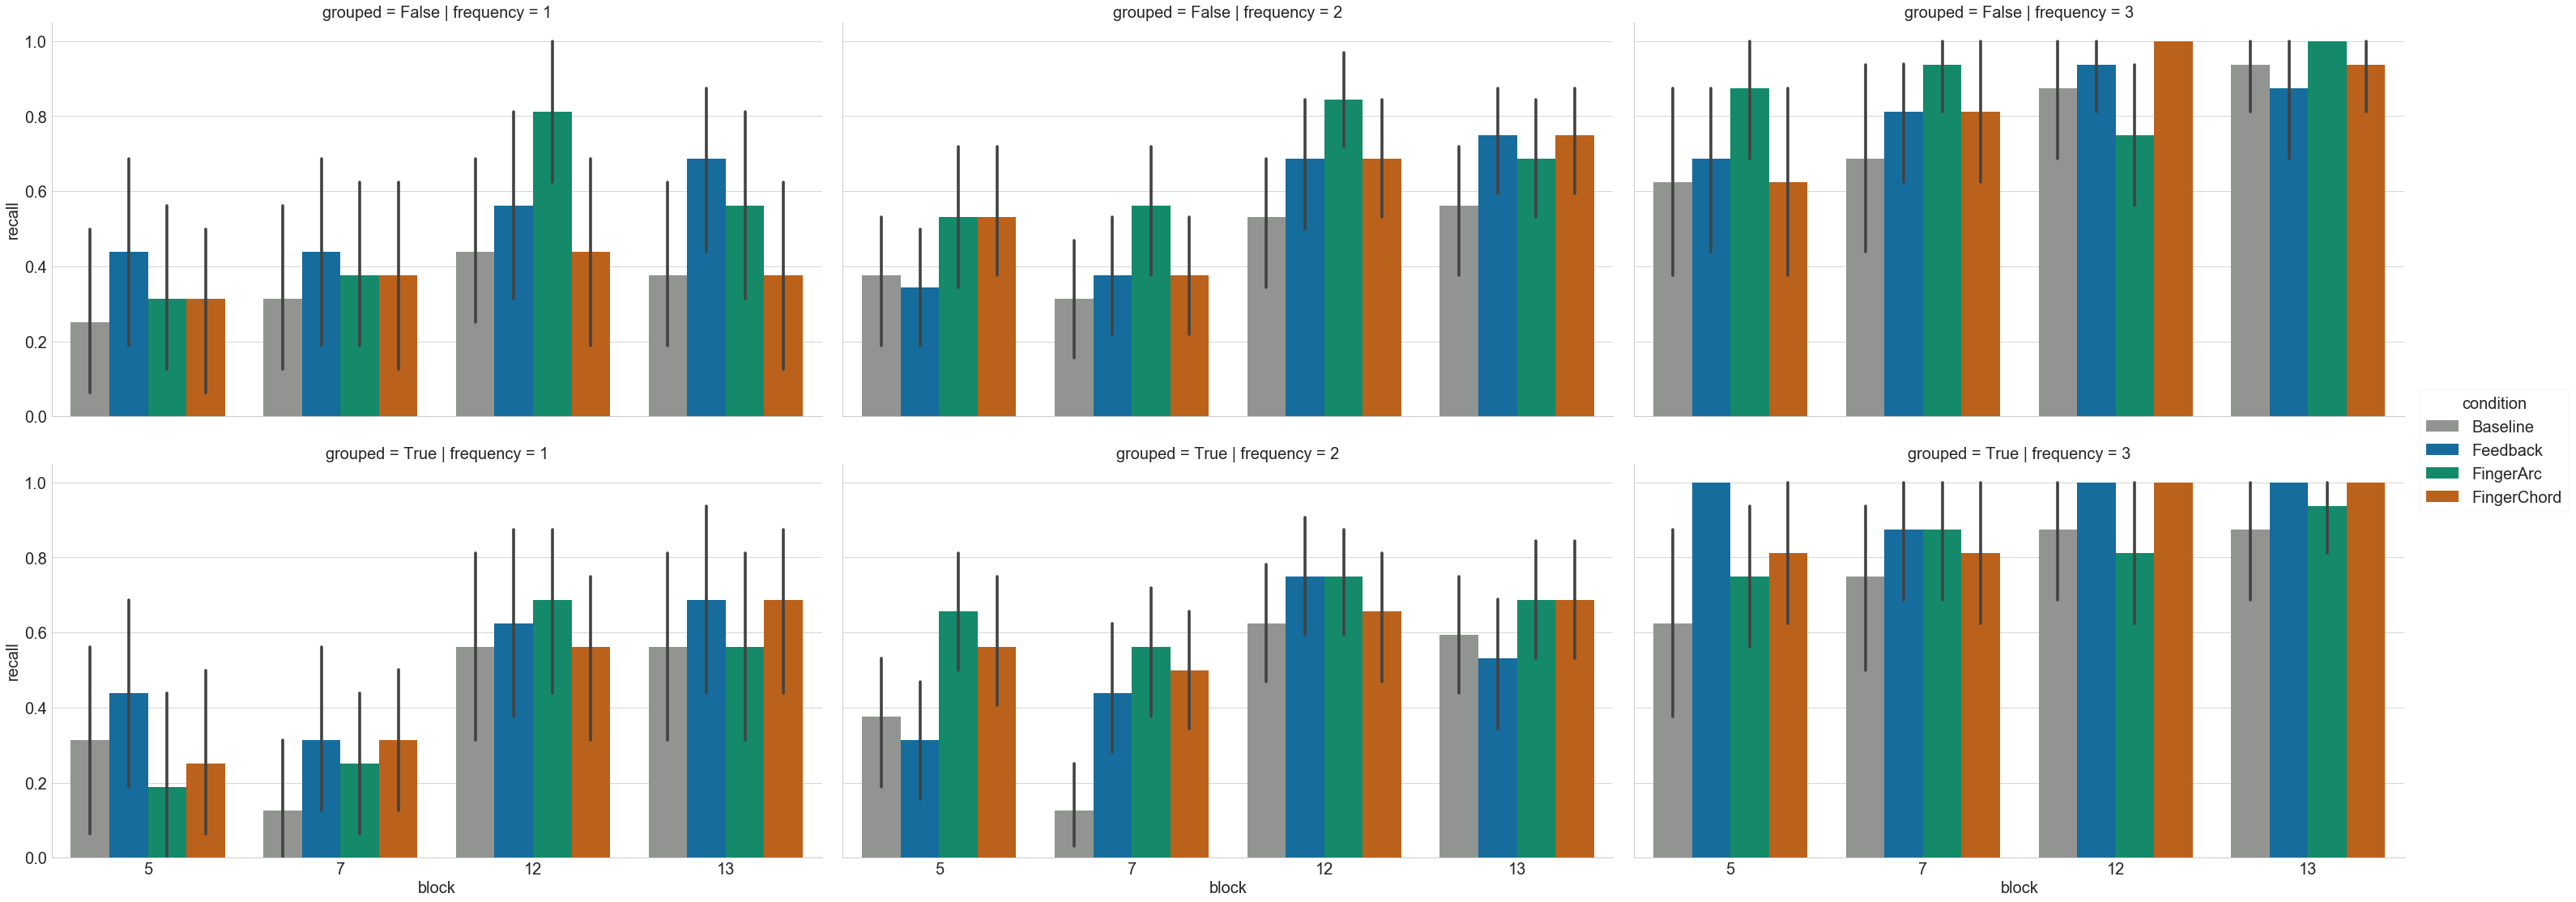

In [52]:
sns.factorplot(x='block', y="recall", hue="condition", row='grouped', col='frequency', kind='bar', data=test, size=height, aspect=width/height)


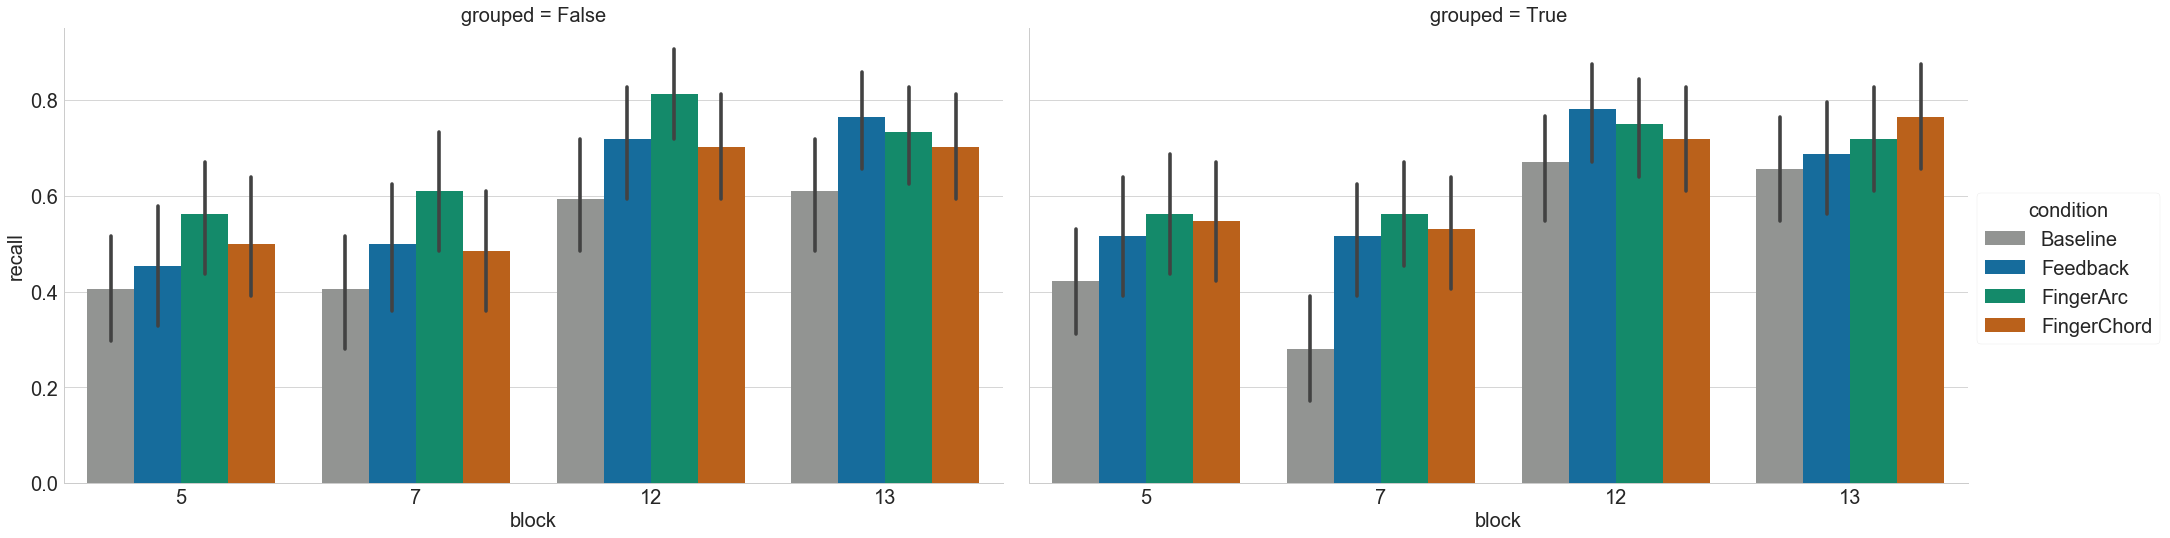

In [53]:
sns.factorplot(x='block', y="recall", hue="condition", col='grouped', col_wrap=2, kind='bar', data=test, size=height, aspect=width/height)


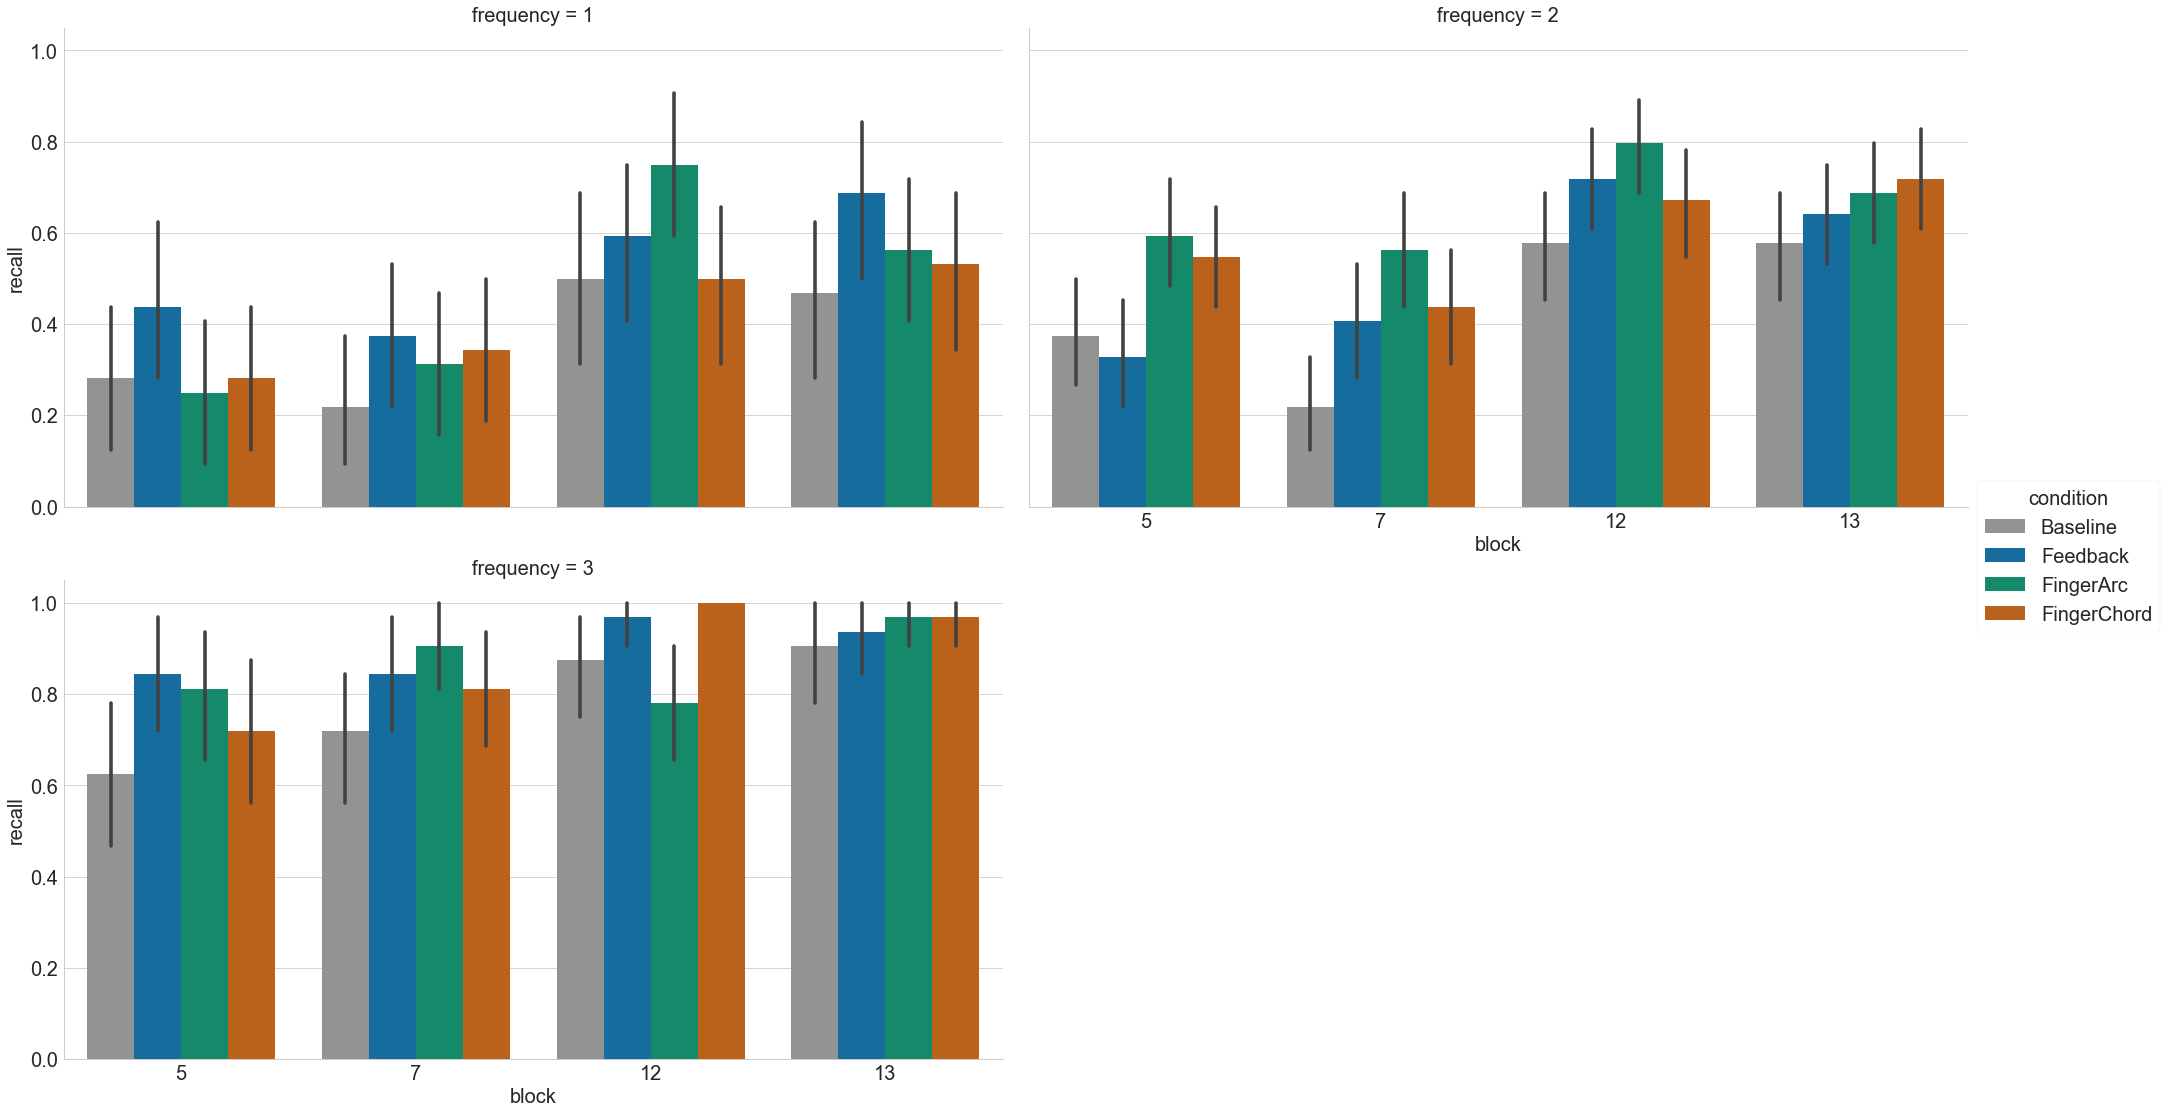

In [54]:
sns.factorplot(x='block', y="recall", hue="condition", col='frequency', col_wrap=2, kind='bar', data=test, size=height, aspect=width/height)


### Time Regression

In [55]:
df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)

In [56]:
# %%R -i df

# df$logTotalTaskTime = log(df$totalTaskTime)

# for(condition in unique(df$condition)) {
#     print('----------')
#     print(condition)
#     print('----------')
    
#     m <- lm(logTotalTaskTime ~ block, data=df[df$condition == condition, ])
#     print(summary(m))
#     plot(df$block, df$logTotalTaskTime)
#     abline(m)
# }


In [57]:
%%R -i df

options(contrasts=c('contr.sum','contr.poly'))

df$condition = factor(df$condition, ordered = FALSE)

df$logTotalTaskTime = log(df$totalTaskTime)
m <- lm(logTotalTaskTime ~ condition + block - 1, data=df)
print(summary(m))
summary(aov(m))


Call:
lm(formula = logTotalTaskTime ~ condition + block - 1, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63303 -0.15428 -0.01143  0.11644  0.81825 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
conditionBaseline     8.442602   0.040759 207.136   <2e-16 ***
conditionFeedback     8.406113   0.040759 206.240   <2e-16 ***
conditionFingerArc    8.277627   0.040759 203.088   <2e-16 ***
conditionFingerChord  8.236413   0.040759 202.077   <2e-16 ***
block                -0.039750   0.004296  -9.252   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2526 on 251 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.999 
F-statistic: 5.271e+04 on 5 and 251 DF,  p-value: < 2.2e-16

           Df Sum Sq Mean Sq F value Pr(>F)    
condition   4  16807    4202 65865.8 <2e-16 ***
block       1      5       5    85.6 <2e-16 ***
Residuals 251     16       0               

In [58]:
%%R -i df

options(contrasts=c('contr.sum','contr.poly'))

df$condition = factor(df$condition, ordered = FALSE)

df$logTotalTaskTime = log(df$totalTaskTime)
m <- lm(logTotalTaskTime ~ condition * block, data=df)
print(summary(m))
summary(aov(m))


Call:
lm(formula = logTotalTaskTime ~ condition * block, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64448 -0.14158 -0.01236  0.12520  0.82363 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       8.340689   0.030339 274.920   <2e-16 ***
condition1        0.118055   0.052548   2.247   0.0255 *  
condition2        0.036380   0.052548   0.692   0.4894    
condition3       -0.025533   0.052548  -0.486   0.6275    
block            -0.039750   0.004312  -9.218   <2e-16 ***
condition1:block -0.002690   0.007469  -0.360   0.7190    
condition2:block  0.004841   0.007469   0.648   0.5175    
condition3:block -0.006255   0.007469  -0.837   0.4031    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2535 on 248 degrees of freedom
Multiple R-squared:  0.3178,	Adjusted R-squared:  0.2986 
F-statistic:  16.5 on 7 and 248 DF,  p-value: < 2.2e-16

                 Df Sum Sq Mean Sq F val

In [59]:
df = training.groupby(['condition', 'participant', 'block', 'grouped'], as_index=False).agg(training_quantitative_columns)

In [60]:
%%R -i df

options(contrasts=c('contr.sum','contr.poly'))

df$condition = factor(df$condition, ordered = FALSE)
df <- df[df$grouped == FALSE,]
# df$logTotalTaskTime = log(df$totalTaskTime)

m <- lm(log(totalTaskTime) ~ condition * log(block) - 1, data=df)
print(summary(m))
print(summary(aov(m)))
# print(lsmeans(m, list(pairwise ~ condition), adjust = "tukey"))

# qplot(x = block, y = logTotalTaskTime, data = df, color = condition) +
#   geom_smooth(method = "lm") 


ggplot(df, aes(x=log(block), y=log(totalTaskTime))) + 
    geom_point() + 
    stat_smooth(method=lm) + 
    geom_line(aes(y=.fitted), colour="red", data=m) +
    facet_grid(. ~ factor(condition))
# qplot(x = block, y = totalTaskTime, data = df, color = condition) +
#   geom_smooth(method = "auto") 


Call:
lm(formula = log(totalTaskTime) ~ condition * log(block) - 1, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98383 -0.17207 -0.01025  0.13033  0.96421 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
conditionBaseline      8.9896903  0.0783530 114.733  < 2e-16 ***
conditionFeedback      8.4511248  0.0783530 107.860  < 2e-16 ***
conditionFingerArc     8.3892051  0.0783530 107.069  < 2e-16 ***
conditionFingerChord   8.2373387  0.0783530 105.131  < 2e-16 ***
log(block)            -0.2108168  0.0227073  -9.284  < 2e-16 ***
condition1:log(block) -0.1229959  0.0393301  -3.127  0.00197 ** 
condition2:log(block)  0.0637649  0.0393301   1.621  0.10623    
condition3:log(block) -0.0001341  0.0393301  -0.003  0.99728    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.297 on 248 degrees of freedom
Multiple R-squared:  0.9987,	Adjusted R-squared:  0.9987 
F-statistic: 2.44e+04 on 8 a

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in ggplot(df, aes(x = log(block), y = log(totalTaskTime))) : 
  could not find function "ggplot"

  warnings.warn(x, RRuntimeWarning)


In [61]:
%%R -i df
require(minpack.lm)
# https://stackoverflow.com/questions/9237068/r-power-fit-with-nls-different-from-excellibrary("poweRlaw")
df$condition = factor(df$condition, ordered = FALSE)
df <- df[df$grouped == FALSE,]


dfb <- df[df$condition == 'Baseline',]
# print(summary(lm(log(totalTaskTime) ~ log(block), data=dfb)))
print(summary(nlsLM(totalTaskTime ~ a * block^-b + c, data=dfb, start=list(a=exp(0.33381), b=2.011, c=1))))

# print(summary(nls(totalTaskTime ~ a * block^b, data=dfb, start=list(a=exp(0.33381), b=-2.011))))
# df$logTotalTaskTime = log(df$totalTaskTime)

# exp(0.33381)
# -2.011

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: minpack.lm

  warnings.warn(x, RRuntimeWarning)



Formula: totalTaskTime ~ a * block^-b + c

Parameters:
    Estimate Std. Error t value Pr(>|t|)
a -1.488e+04  8.855e+04  -0.168    0.867
b -1.046e-01  5.458e-01  -0.192    0.849
c  2.291e+04  8.902e+04   0.257    0.798

Residual standard error: 2062 on 61 degrees of freedom

Number of iterations till stop: 50 
Achieved convergence tolerance: 1.49e-08
Reason stopped: Number of iterations has reached `maxiter' == 50.



### Modality

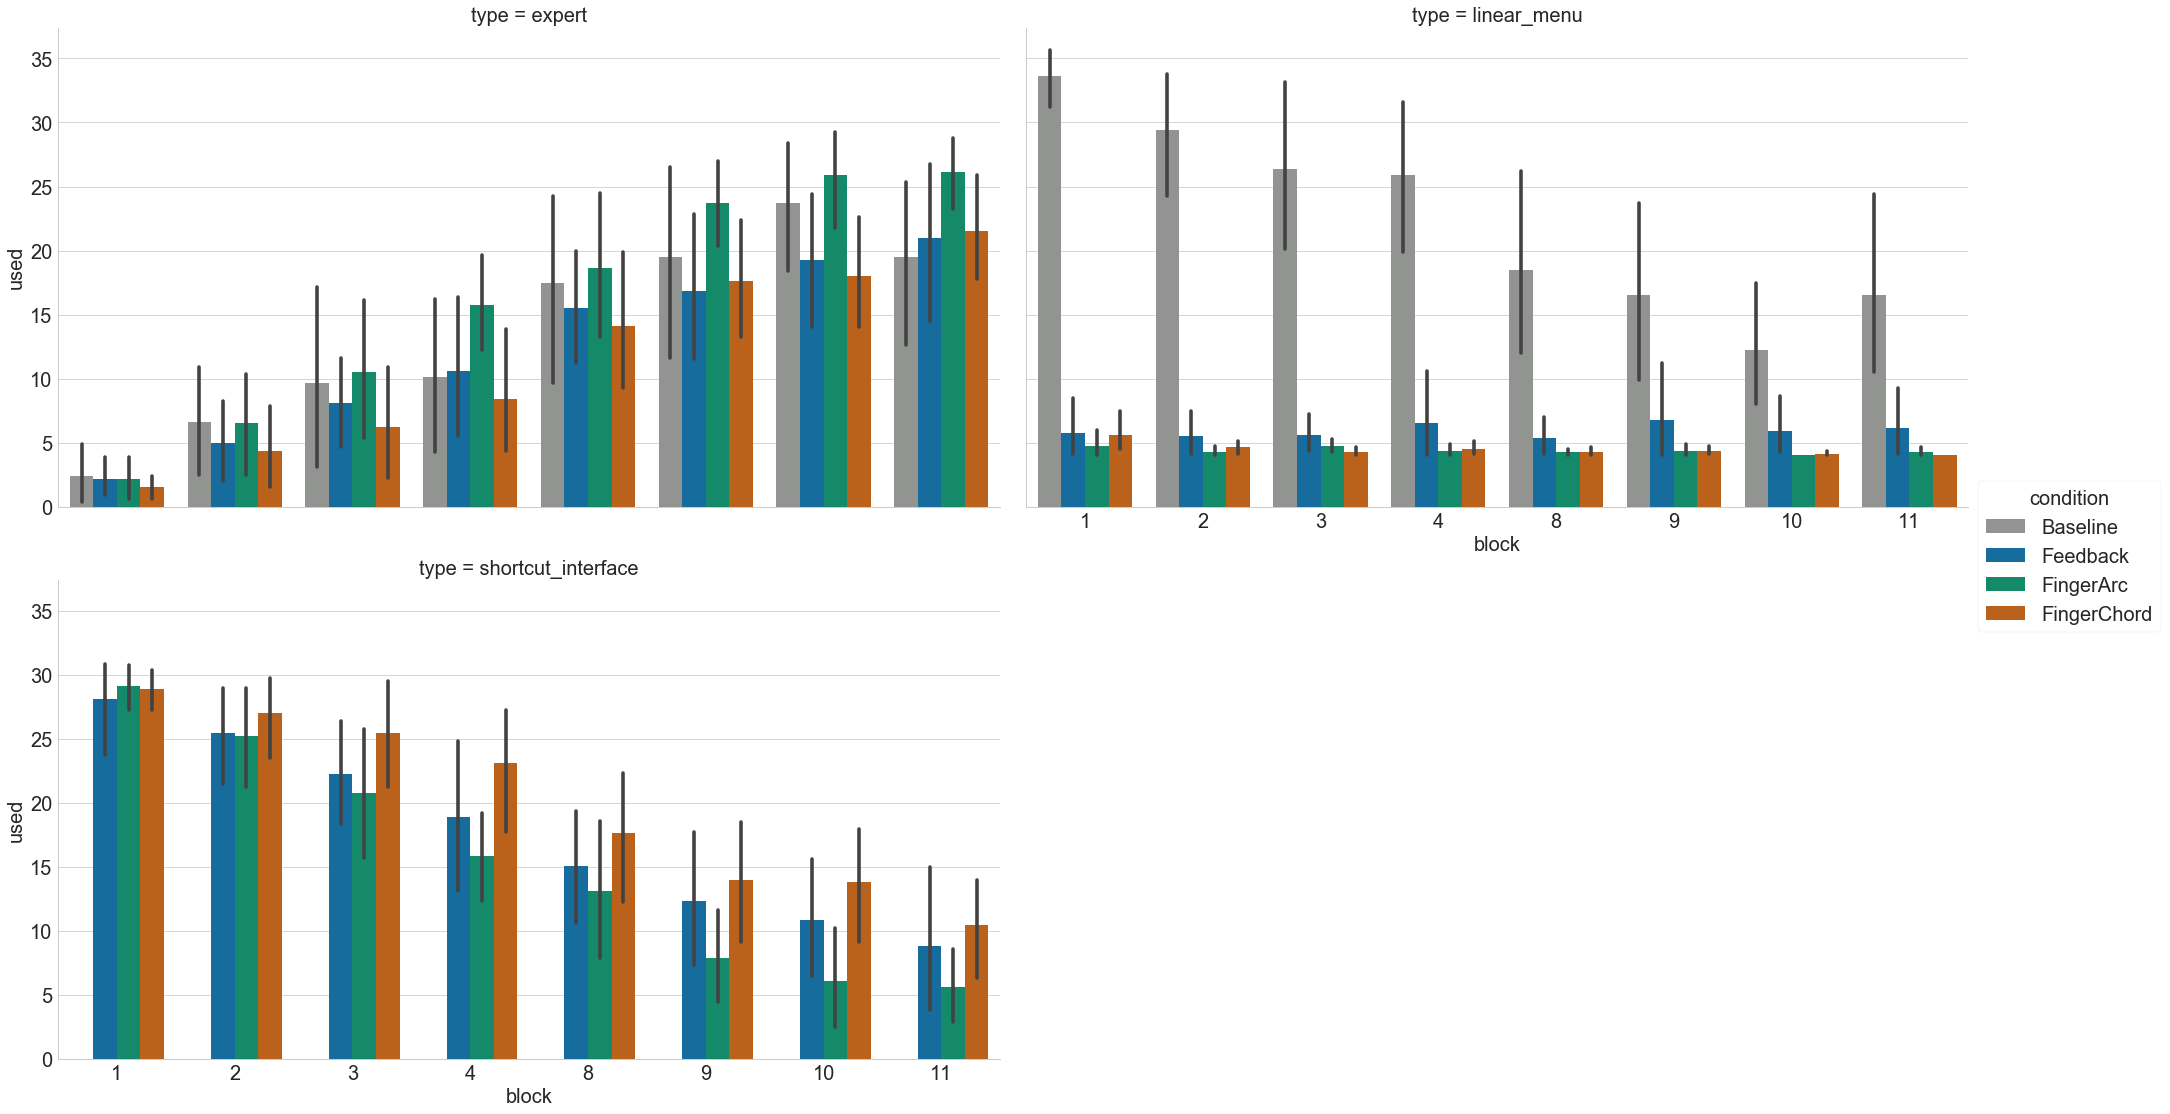

In [62]:
df = training[['condition', 'participant', 'block', 'trial', 'selection_type']].copy()
df['shortcut_interface'] = (df['selection_type'] == 'shortcut_interface').map(int)
df['expert'] = (df['selection_type'] == 'expert').map(int)
df['linear_menu'] = (df['selection_type'] == 'linear_menu').map(int)

del df['selection_type']

df = df.melt(id_vars=['condition', 'participant', 'block', 'trial'], value_name='used', var_name='type')
dff = df.groupby(['condition', 'participant', 'block', 'type'], as_index=False).sum()

sns.factorplot(x='block', 
               hue='condition', 
               y='used', 
               col='type', 
               col_wrap=2,  
               data=dff, 
               kind='bar', 
               size=height,
               aspect=width/height)

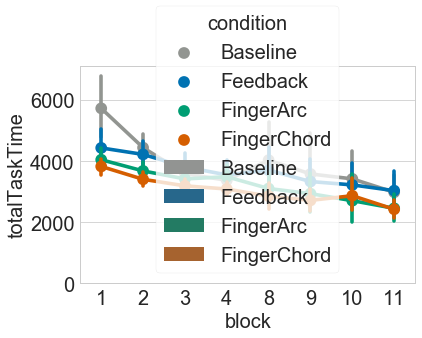

In [63]:
fig, ax = plt.subplots()
d = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
sns.plotting_context("notebook")
with sns.color_palette(sns.xkcd_palette(['grey']) + sns.color_palette('colorblind', 3), desat=0.75) :
    sns.barplot(x='block', 
                   hue='condition', 
                   y='expert_use', 
                   data=d, 
                    ci=None,
    #                kind='bar', 
    #                size=height,
    #                aspect=width/height,
    #                 legend=False,
                    )

sns.pointplot(x='block',
              hue='condition',
              y='totalTaskTime', 
              data = d,
#               size=height,
#               aspect=width/height,
#                kind='point',
#                legend=False,
              )

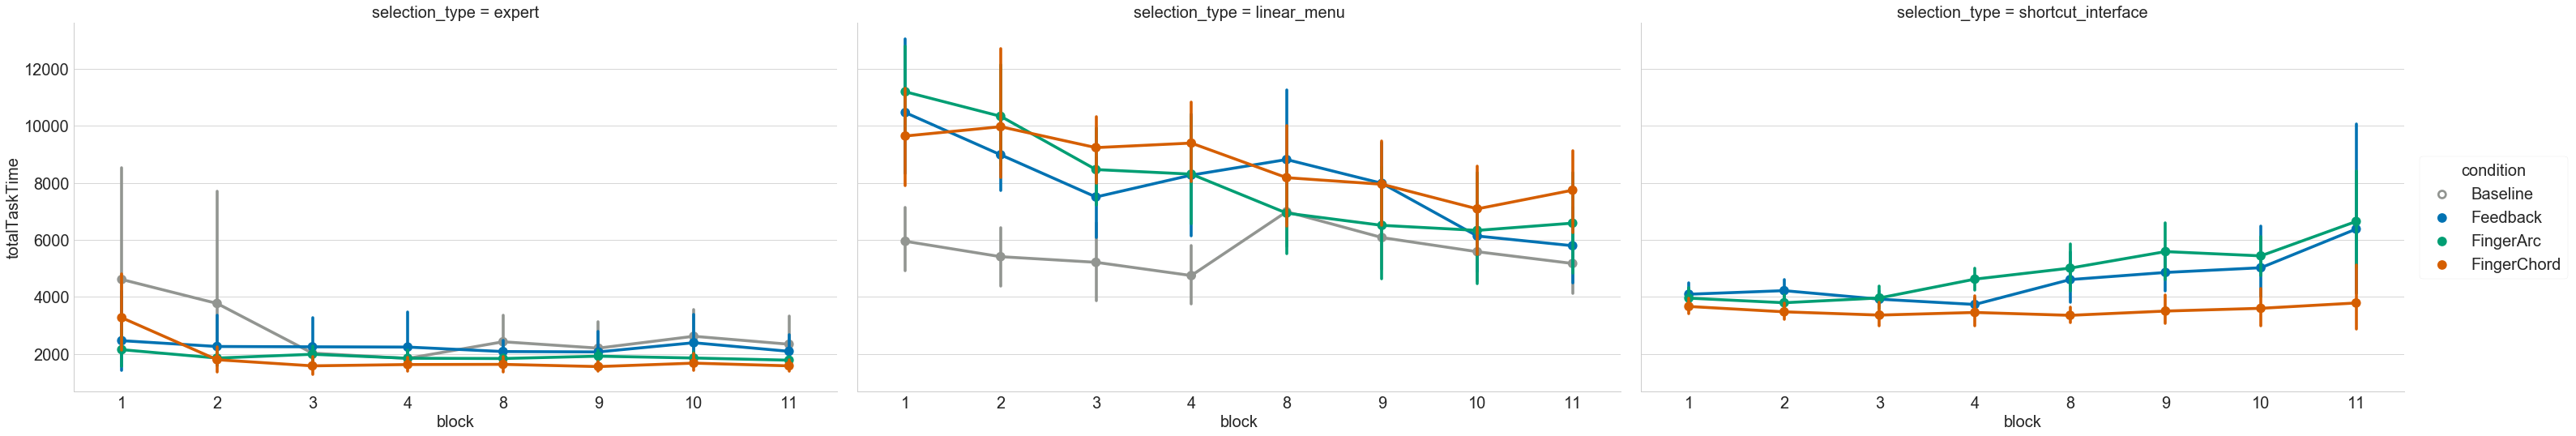

In [64]:
sns.factorplot(x='block', hue='condition', y='totalTaskTime', col='selection_type', 
              data=training.groupby(['condition', 'participant','block', 'selection_type'], as_index=False).agg(training_quantitative_columns),
             size=height,
               aspect=width/height)

In [65]:
%%R -i df

options(contrasts=c('contr.sum','contr.poly'))

df$condition = factor(df$condition, ordered = FALSE)
df$grouped = factor(df$grouped, ordered = FALSE)

m <- lm(expert_use ~ condition + block + grouped, data=df)
print(summary(m))
summary(aov(m))

lsmeans(m, list(pairwise ~ condition), adjust = "tukey")


Error in `$<-.data.frame`(`*tmp*`, grouped, value = integer(0)) : 
  replacement has 0 rows, data has 27648


/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in `$<-.data.frame`(`*tmp*`, grouped, value = integer(0)) : 
  replacement has 0 rows, data has 27648

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: In nls.lm(par = start, fn = FCT, jac = jac, control = control, lower = lower,  :
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  lmdif: info = -1. Number of iterations has reached `maxiter'

### Regression Models

In [66]:
%%R -i training

training$condition = factor(training$condition)
training$block = factor(training$block)
training$trial = factor(training$trial)

m <- lmer(finalTaskTime ~ condition * grouped * block + (1|participant), data=training)
print(summary(m))
Anova(m)
# m <- ezANOVA(dv=finalTaskTime, within=c(frequency, block), between=condition, wid=participant, data=training)
# ezDesign(data=training, x=trial, y=block, row=frequency, col=condition)


/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Correlation matrix not shown by default, as p = 64 > 12.
Use print(summary(m), correlation=TRUE)  or
	 vcov(summary(m))	 if you need it


  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: finalTaskTime ~ condition * grouped * block + (1 | participant)
   Data: training

REML criterion at convergence: 180508.1

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.051 -0.358 -0.149  0.131 53.665 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept)   711411  843.5  
 Residual                20429000 4519.8  
Number of obs: 9216, groups:  participant, 32

Fixed effects:
                              Estimate Std. Error t value
(Intercept)                  3918.2585   156.3595  25.059
condition.L                 -1009.2025   312.7189  -3.227
condition.Q                   383.6936   312.7189   1.227
condition.C                    27.9175   312.7189   0.089
grouped1                      485.1181    47.0817  10.304
block1                       1592.9863   124.5665  12.788
block2                        670.6547   124.5665   5.384
block3                         39.0532   124.5665   0.314
blo

In [67]:
%%R -i training

training$condition = factor(training$condition)
training$block = factor(training$block)
training$trial = factor(training$trial)

contrasts(training$condition) <- "contr.sum"
contrasts(training$block) <- "contr.sum"
contrasts(training$trial) <- "contr.sum"

m <- glmer(errors ~ condition + (1|condition:trial)+ (1|participant), family=poisson, data=training)

print(Anova(m, type=3))

summary(glht(m, lsm(pairwise ~ condition)), test=adjusted(type="holm"))

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: errors
             Chisq Df Pr(>Chisq)    
(Intercept) 178.90  1     <2e-16 ***
condition     3.16  3     0.3676    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	 Simultaneous Tests for General Linear Hypotheses

Fit: glmer(formula = errors ~ condition + (1 | condition:trial) + 
    (1 | participant), data = training, family = poisson)

Linear Hypotheses:
                             Estimate Std. Error z value Pr(>|z|)
Baseline - Feedback == 0     -0.01821    0.40318  -0.045    1.000
Baseline - FingerArc == 0    -0.34535    0.40219  -0.859    1.000
Baseline - FingerChord == 0   0.36525    0.40479   0.902    1.000
Feedback - FingerArc == 0    -0.32714    0.39822  -0.822    1.000
Feedback - FingerChord == 0   0.38345    0.40099   0.956    1.000
FingerArc - FingerChord == 0  0.71060    0.40003   1.776    0.454
(Adjusted p values reported -- holm method)



In [68]:
%%R -i training

training$condition = factor(training$condition)
training$block = factor(training$block)
training$trial = factor(training$trial)

contrasts(training$condition) <- "contr.sum"
contrasts(training$block) <- "contr.sum"
contrasts(training$trial) <- "contr.sum"

# m <- lmer(totalTimeMedian ~ condition / trial + (1|participant), data=training)
m <- glmer(recall ~ condition + (1|condition:trial)+ (1|participant), family=binomial(link="logit"), data=training)

print(Anova(m, type=3))

summary(glht(m, lsm(pairwise ~ condition)), test=adjusted(type="holm"))

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: recall
              Chisq Df Pr(>Chisq)    
(Intercept) 47.6511  1  5.092e-12 ***
condition    3.9967  3     0.2618    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	 Simultaneous Tests for General Linear Hypotheses

Fit: glmer(formula = recall ~ condition + (1 | condition:trial) + 
    (1 | participant), data = training, family = binomial(link = "logit"))

Linear Hypotheses:
                             Estimate Std. Error z value Pr(>|z|)
Baseline - Feedback == 0     -0.05184    0.35637  -0.145    1.000
Baseline - FingerArc == 0    -0.58207    0.35548  -1.637    0.508
Baseline - FingerChord == 0   0.03039    0.35623   0.085    1.000
Feedback - FingerArc == 0    -0.53023    0.35507  -1.493    0.541
Feedback - FingerChord == 0   0.08223    0.35583   0.231    1.000
FingerArc - FingerChord == 0  0.61246    0.35490   1.726    0.506
(Adjusted p values reported -- holm method)



In [69]:
%%R -i training

training$condition = factor(training$condition)
training$block = factor(training$block)
training$trial = factor(training$trial)

contrasts(training$condition) <- "contr.sum"
contrasts(training$block) <- "contr.sum"
contrasts(training$trial) <- "contr.sum"

m = glmer(errors ~ (block * condition) + (1|block:condition:trial) + (1|participant), data=training, family=poisson, nAGQ=0)
Anova(m, type=3)

# with(training, interaction.plot(block, condition, errors)) # for convenience
# summary(glht(m, lsm(pairwise ~ block * condition)), test=adjusted(type="holm"))


Analysis of Deviance Table (Type III Wald chisquare tests)

Response: errors
                   Chisq Df Pr(>Chisq)    
(Intercept)     186.8438  1  < 2.2e-16 ***
block            63.8032  7  2.615e-11 ***
condition         2.8794  3  0.4106017    
block:condition  46.8642 21  0.0009794 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [70]:
%%R -i training

training$condition = factor(training$condition)
training$block = factor(training$block)
training$trial = factor(training$trial)

contrasts(training$condition) <- "contr.sum"
contrasts(training$block) <- "contr.sum"
contrasts(training$trial) <- "contr.sum"

m = glmer(successful_expert ~ (block * condition) + (1|block:condition:trial) + (1|participant), data=training, family=binomial(link="logit"), nAGQ=0)
Anova(m, type=3)

# with(training, interaction.plot(block, condition, errors)) # for convenience
# summary(glht(m, lsm(pairwise ~ block * condition)), test=adjusted(type="holm"))


Error in eval(predvars, data, env) : object 'successful_expert' not found


/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in eval(predvars, data, env) : object 'successful_expert' not found

  warnings.warn(x, RRuntimeWarning)


Analysis of Deviance Table (Type III Wald chisquare tests)

Response: finalTaskTimeMedian
                  Chisq Df Pr(>Chisq)    
(Intercept)     627.969  1  < 2.2e-16 ***
block           242.859  7  < 2.2e-16 ***
condition        11.928  3  0.0076334 ** 
block:condition  51.819 21  0.0002026 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = finalTaskTimeMedian ~ (block * condition) + (1 | 
    participant), data = training)

Linear Hypotheses:
                             Estimate Std. Error z value Pr(>|z|)  
Feedback - Baseline == 0      -810.05     442.25  -1.832   0.2680  
FingerArc - Baseline == 0    -1298.84     442.25  -2.937   0.0166 *
FingerChord - Baseline == 0  -1341.50     442.25  -3.033   0.0145 *
FingerArc - Feedback == 0     -488.78     442.25  -1.105   0.6884  
FingerChord - Feedback == 0   -531.45     442.25  -1.202   0.6884 

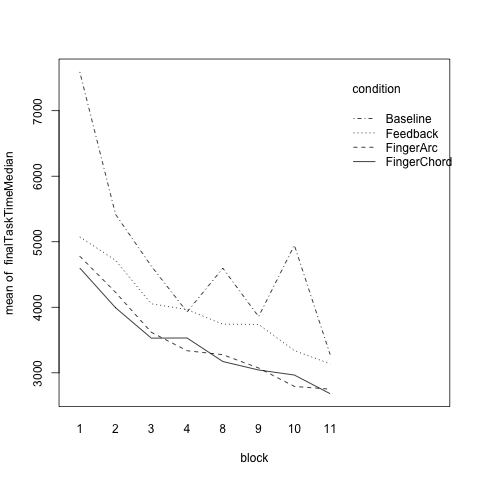

In [71]:
%%R -i training

training$condition = factor(training$condition)
training$block = factor(training$block)
training$trial = factor(training$trial)

contrasts(training$condition) <- "contr.sum"
contrasts(training$block) <- "contr.sum"
contrasts(training$trial) <- "contr.sum"

# m = glmer(successful_expert ~ (block * condition) + (1|block:condition:trial) + (1|participant), data=training, family=binomial(link="logit"), nAGQ=0)

# m = lmer(totalTime ~ (block * condition) + (1|block:condition:trial) + (1|participant), data=training)
m = lmer(finalTaskTimeMedian ~ (block * condition) + (1|participant), data=training)

print(Anova(m, type=3))

with(training, interaction.plot(block, condition, finalTaskTimeMedian)) # for convenience
# summary(glht(m, lsm(pairwise ~ block * condition)), test=adjusted(type="holm"))
# lsmeans(m, list(pairwise ~ block * condition), adjust = "tukey")
summary(glht(m, linfct = mcp(condition = "Tukey")), test = adjusted("holm"))

## Final

### Recall

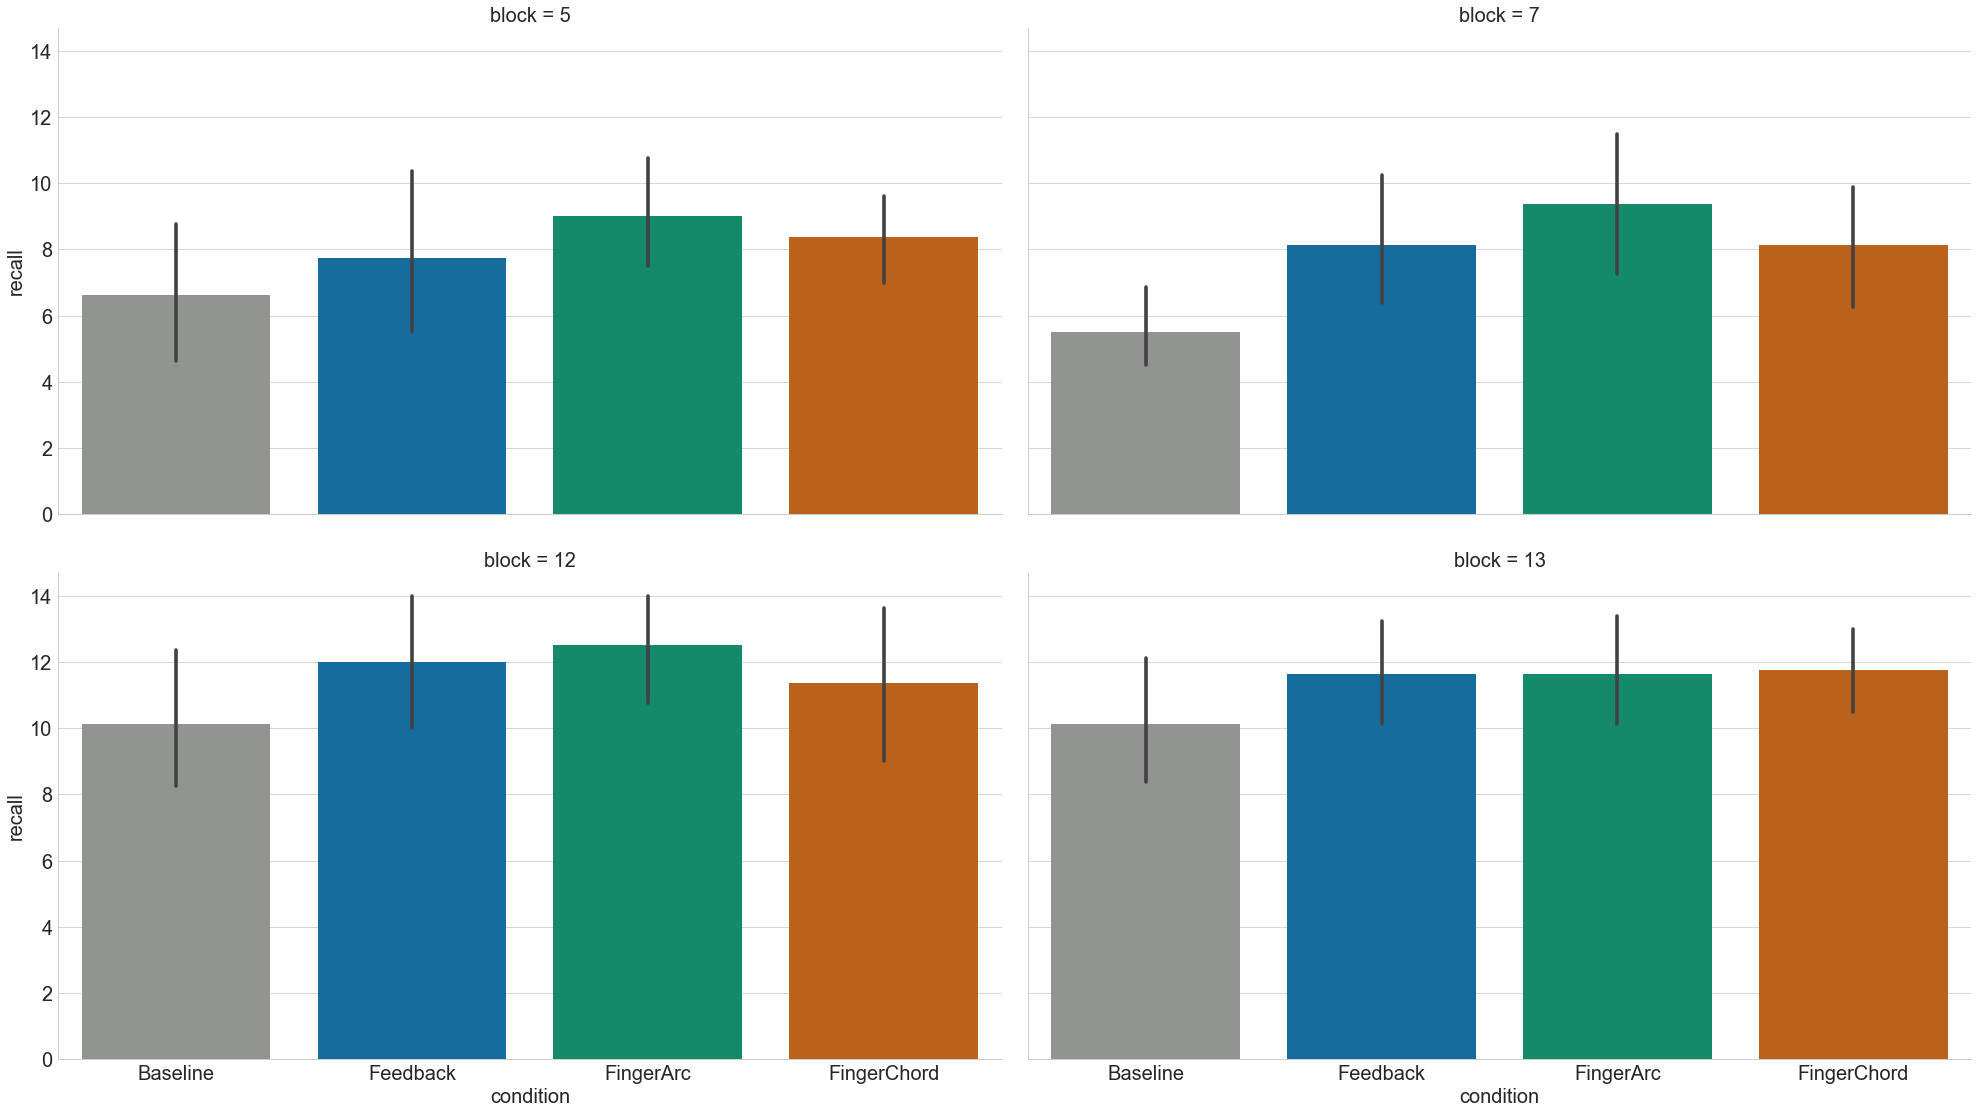

In [72]:
df = test.groupby(['condition', 'participant', 'block'], as_index=False).agg(test_quantitative_columns)

sns.factorplot(x='condition', y="recall", col='block', kind='bar', data=df, size=height, col_wrap=2, aspect=width/height, legend_out=False)

In [73]:
%%R -i df

df$block = factor(df$block)

df$condition = factor(df$condition)
df$participant = factor(df$participant)

for (block in c(5,7, 12, 13)) {
    blocked <- df[df$block == block,]

    m <- ezANOVA(data = blocked, 
          wid = participant, 
          dv = recall, 
          between = condition,
          return_aov=TRUE)

    print(m)
}

$ANOVA
     Effect DFn DFd         F         p p<.05        ges
1 condition   3  28 0.9295585 0.4394139       0.09057471

$`Levene's Test for Homogeneity of Variance`
  DFn DFd   SSn   SSd        F         p p<.05
1   3  28 10.25 87.75 1.090218 0.3694761      

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                condition Residuals
Sum of Squares     24.625   247.250
Deg. of Freedom         3        28

Residual standard error: 2.971592
Estimated effects are balanced

$ANOVA
     Effect DFn DFd        F          p p<.05       ges
1 condition   3  28 2.664617 0.06717378       0.2220894

$`Levene's Test for Homogeneity of Variance`
  DFn DFd     SSn     SSd         F         p p<.05
1   3  28 5.59375 114.125 0.4574662 0.7141582      

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                condition Residuals
Sum of Squares   63.84375 223.62500
Deg. of Freedom         3        28

Residual standard error: 2.826059
Estimate

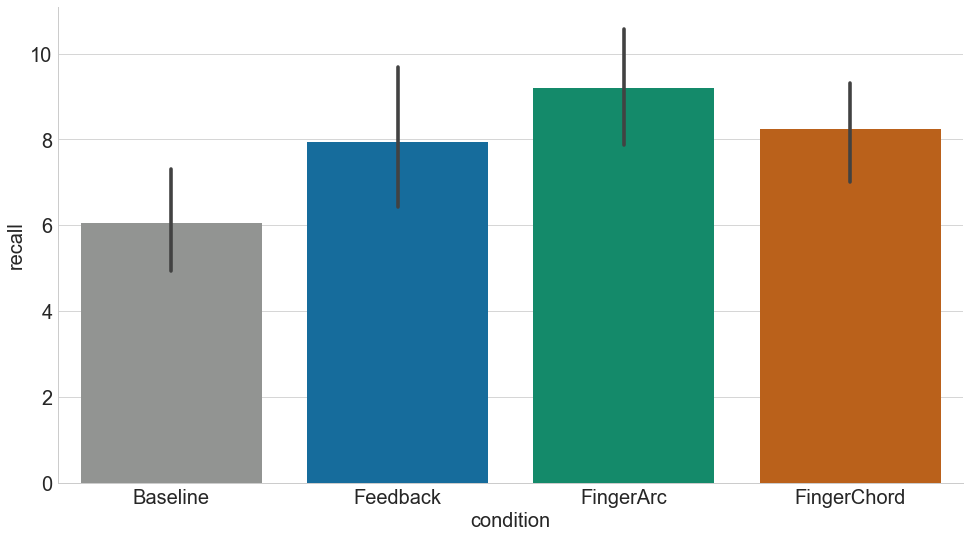

In [74]:
df = test[test['block'] <= 7].groupby(['condition', 'participant', 'block'], as_index=False).agg(test_quantitative_columns)
sns.factorplot(x='condition', y="recall", kind='bar', data=df, size=height,aspect=width/height, legend_out=False)


In [75]:
%%R -i df

df$block = factor(df$block)
df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = recall, 
      between = condition,
      return_aov=TRUE)

print(m)

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

  warnings.warn(x, RRuntimeWarning)


$ANOVA
     Effect DFn DFd        F         p p<.05       ges
1 condition   3  28 1.943523 0.1454807       0.1723462

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn      SSd         F         p p<.05
1   3  28 1.023437 91.40625 0.1045014 0.9567536      

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                condition Residuals
Sum of Squares   41.21094 197.90625
Deg. of Freedom         3        28

Residual standard error: 2.658586
Estimated effects are balanced



#### Grouped

FileNotFoundError: [Errno 2] No such file or directory: 'figures/recall_grouped.pdf'

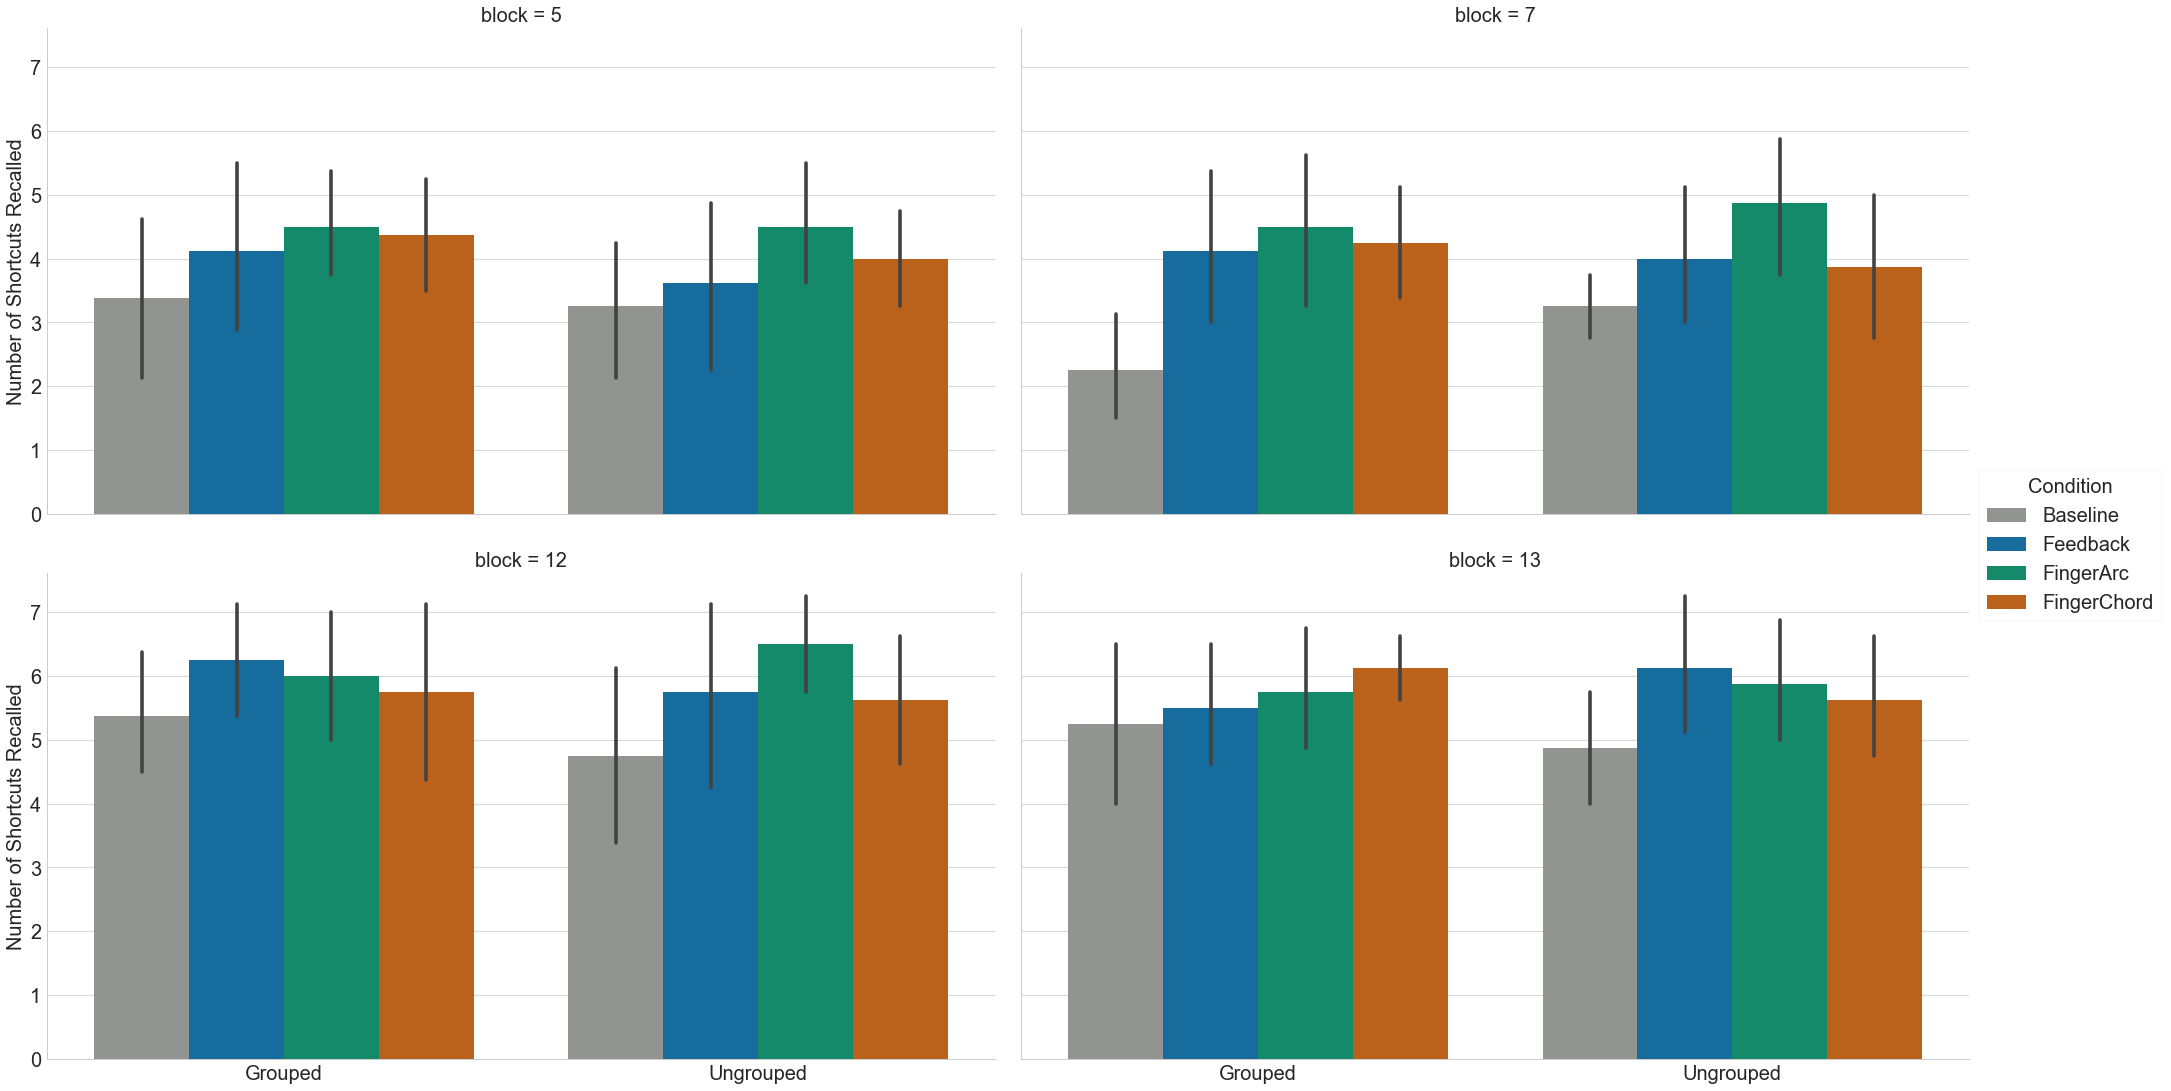

In [76]:
df = test.groupby(['condition', 'participant', 'block', 'Grouped'], as_index=False).agg(test_quantitative_columns)
# df['Time Passed'] = df["block"].astype('str').replace({'7' : '10 min', '13':'24 hours'})
df['Condition'] = df['condition']
g = sns.factorplot(x='Grouped', y="recall", hue='Condition', col='block', col_wrap=2, kind='bar', data=df, size=height, aspect=width/height)

g.set_axis_labels("", "Number of Shortcuts Recalled")

g.savefig('figures/recall_grouped.pdf')

In [ ]:
df = test.groupby(['condition', 'participant', 'block', 'Grouped'], as_index=False).agg(test_quantitative_columns)
# df['Time Passed'] = df["block"].astype('str').replace({'7' : '10 min', '13':'24 hours'})
df = df[df['block'] <= 7]
df['Condition'] = df['condition']
g = sns.factorplot(x='Grouped', y="recall", hue='Condition',  kind='bar', data=df, size=height, aspect=width/height)

g.set_axis_labels("", "Number of Shortcuts Recalled")


In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$Grouped = factor(df$Grouped)

df7 = df[df$block <= 7,]
m <- aov(recall ~ condition * Grouped + Error(participant / Grouped), data = df7)
print(summary(m))


In [ ]:
df = test[test['block'].isin([7,13])].groupby(['condition', 'participant', 'block', 'Grouped', 'frequency'], as_index=False).agg(test_quantitative_columns)
df['Time Passed'] = df["block"].astype('str').replace({'7' : '10 min', '13':'24 hours'})
df['Condition'] = df['condition']
df = test[test['block'].isin([7,13])].groupby(['condition', 'participant', 'block', 'Grouped', 'frequency'], as_index=False).agg(test_quantitative_columns)
df['Time Passed'] = df["block"].astype('str').replace({'7' : '10 min', '13':'24 hours'})
df['Condition'] = df['condition']
g = sns.factorplot(x='Grouped', y="recall", hue='Condition', col='frequency', row='Time Passed', kind='bar', data=df, size=height, aspect=width/height)

g = sns.factorplot(x='Grouped', y="recall", hue='Condition', col='frequency', row='Time Passed', kind='bar', data=df, size=height, aspect=width/height)

g.set_axis_labels("", "Number of Shortcuts Recalled")

g.savefig('figures/recall_grouped.pdf')

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$Grouped = factor(df$Grouped)

df7 = df[df$block == 7,]
df13 = df[df$block == 13,]

m <- ezANOVA(data = df7, 
      wid = participant, 
      dv = recall, 
      between = condition,
      within = Grouped,
      return_aov=TRUE)


print(m)

m <- ezANOVA(data = df13, 
      wid = participant, 
      dv = recall, 
      between = condition,
      within = Grouped,
      return_aov=TRUE)


print(m)



In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$Grouped = factor(df$Grouped)

df7 = df[df$block == 7,]
summary(aov(recall ~ condition * Grouped + Error(participant/Grouped), data=df7))

### Selection Type

#### Entire Experiment

In [ ]:
df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='block', hue='condition', kind='count', col='selection_type', col_wrap=2
               , data=training, size=height, aspect=width/height)

In [ ]:
df = training

In [ ]:
df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='block', hue='selection_type', kind='count', col='condition', col_wrap=2
               , data=training, size=height, aspect=width/height)

In [ ]:
df = training.copy()
df['new'] = df['selection_type'] == 'shortcut'
sns.factorplot(x='block', 
               hue='condition', 
               kind='count', 
               col='new', 
               data=df, 
               size=height, 
               aspect=width/height)

### Guidance Vs. Expert

#### Grouped Over Time

In [ ]:
df = training.groupby(['Condition', 'participant', 'block', 'Grouped'], as_index=False).agg(training_quantitative_columns)
df['Rate of Linear Menu Use']= df['used_linear_menu']
df['Block'] = df['block']

sns.factorplot(x='block', hue='Condition', y='Rate of Linear Menu Use', row='Grouped', kind='point', data=df, size=height, aspect=width/height)


g.set_titles("{row_name}")
g.set(ylim=(0, None))
g.savefig('figures/linear_menu_use_grouped_block.pdf')

In [ ]:
%%R -i df

df$Condition = factor(df$Condition)
df$participant = factor(df$participant)
df$Grouped = factor(df$Grouped)
df$block = factor(df$block)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = used_linear_menu, 
      between = Condition,
      within=c(block, Grouped),
      return_aov=TRUE)

print(m)

### Used Linear Menu

#### Grouped Over Time

In [ ]:
df = training.groupby(['Condition', 'participant', 'block', 'Grouped'], as_index=False).agg(training_quantitative_columns)
df['Rate of Linear Menu Use']= df['used_linear_menu']
df['Block'] = df['block']

sns.factorplot(x='block', hue='Condition', y='Rate of Linear Menu Use', row='Grouped', kind='point', data=df, size=height, aspect=width/height)


g.set_titles("{row_name}")
g.set(ylim=(0, None))
g.savefig('figures/linear_menu_use_grouped_block.pdf')

In [ ]:
%%R -i df

df$Condition = factor(df$Condition)
df$participant = factor(df$participant)
df$Grouped = factor(df$Grouped)
df$block = factor(df$block)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = used_linear_menu, 
      between = Condition,
      within=c(block, Grouped),
      return_aov=TRUE)

print(m)

In [ ]:
df = training.groupby(['Condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
df['Rate of Linear Menu Use']= df['used_linear_menu']
df['Block'] = df['block']

sns.factorplot(x='block', hue='Condition', y='Rate of Linear Menu Use', kind='point', data=df, dodge=True, size=height, aspect=width/height)


# g.set_titles("{row_name}")
g.set(ylim=(0, None))
g.savefig('figures/linear_menu_use_block.pdf')

In [ ]:
%%R -i df
# training = df[df$block == 1,]

df$Condition = factor(df$Condition)
df$participant = factor(df$participant)
df$block = factor(df$block)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = used_linear_menu, 
      between = Condition,
      within=c(block),
      return_aov=TRUE)

print(m)

training$condition = training$Condition
val = training
# trues = training[training$Grouped == 'Grouped',]
# falses = training[training$Grouped == 'Ungrouped',]

# val = trues
tbf = t.test(val[val$condition == 'Feedback',]$used_linear_menu, val[val$condition == 'Baseline',]$used_linear_menu)
tfcb = t.test(val[val$condition == 'FingerChord',]$used_linear_menu, val[val$condition == 'Baseline',]$used_linear_menu)
tfcf = t.test(val[val$condition == 'FingerChord',]$used_linear_menu, val[val$condition == 'Feedback',]$used_linear_menu)
tfab = t.test(val[val$condition == 'FingerArc',]$used_linear_menu, val[val$condition == 'Baseline',]$used_linear_menu)
tfaf = t.test(val[val$condition == 'FingerArc',]$used_linear_menu, val[val$condition == 'Feedback',]$used_linear_menu)
tfafc = t.test(val[val$condition == 'FingerArc',]$used_linear_menu, val[val$condition == 'FingerChord',]$used_linear_menu)

# tfcf
# tfaf

# fbf
# ffcf
# ffab
# ffaf
# val = falses

# fbf = t.test(val[val$condition == 'Feedback',]$used_linear_menu, val[val$condition == 'Baseline',]$used_linear_menu)
# ffcb = t.test(val[val$condition == 'FingerChord',]$used_linear_menu, val[val$condition == 'Baseline',]$used_linear_menu)
# ffcf = t.test(val[val$condition == 'FingerChord',]$used_linear_menu, val[val$condition == 'Feedback',]$used_linear_menu)
# ffab = t.test(val[val$condition == 'FingerArc',]$used_linear_menu, val[val$condition == 'Baseline',]$used_linear_menu)
# ffaf = t.test(val[val$condition == 'FingerArc',]$used_linear_menu, val[val$condition == 'Feedback',]$used_linear_menu)
# ffafc = t.test(val[val$condition == 'FingerArc',]$used_linear_menu, val[val$condition == 'FingerChord',]$used_linear_menu)

p.adjust(c(tbf$p.value,tfcb$p.value,tfcf$p.value,tfab$p.value,tfaf$p.value,
           tfafc$p.value
          ), method="holm")

#### Grouped

In [ ]:
df = training.groupby(['condition', 'participant', 'Grouped'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='Grouped', hue='condition', y='used_linear_menu',kind='bar', data=df, size=height, aspect=width/height)


### Expert Attempts

In [ ]:
df = training[training['block'] >= 9].groupby(['condition', 'participant', 'block', 'grouped'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='grouped', hue='condition', y='expert_attempt', kind='bar', data=df, size=height, aspect=width/height)

### Expert Use

#### Entire Experiment

In [ ]:
df = training.groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='expert_use', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      return_aov=TRUE)

print(m)


In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$grouped = factor(df$grouped)


m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      within = grouped,
      return_aov=TRUE)

print(m)

#### Over Time

In [ ]:



df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
df['Expert Use'] = df['expert_use']
df['Block'] = df['block']
df['Condition'] = df['condition']

# sns.pointplot(x='Block', hue='Condition', y='Expert Use', data=df, dodge=True)

fig = sns.factorplot(x='Block', hue='Condition', y='Expert Use', kind='point', data=df, dodge=True, size=height, aspect=width/height, legend_out=False)

fig.set(ylim=(0, None))

fig.fig.set_size_inches(width, height)

# fig.savefig('figures/expert_use_grouped_time.pdf')

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$block = factor(df$block)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      within=block,
      return_aov=TRUE)

print(m)

#### Last Block

In [ ]:
df = training[training['block'] == 11].groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='expert_use', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      return_aov=TRUE)

print(m)

#### Last 3 Blocks

In [ ]:
df = training[training['block'] >= 9].groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)

df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)

sns.factorplot(x='condition', y='expert_use', kind='bar', data=df, size=height, aspect=width/height)

df[['condition', 'participant', 'block', 'expert_use']].head(10)

In [ ]:
%%R -i df

options(contrasts=c('contr.sum','contr.poly'))

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$block = factor(df$block)


m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_attempt, 
      between = condition,
      within=c(block, Grouped),
      return_aov=TRUE)

print(m)

m <- aov(expert_use ~ condition * block + Error(participant / block), data=df, type=2)
print(summary(m))

In [ ]:
df = training[training['block'] >= 9].groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)


In [ ]:
%%R -i df

library(fitdistrplus)

options(contrasts=c('contr.sum','contr.poly'))


df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$block = factor(df$block)

fit = fitdist(df[df$condition == "Baseline",]$expert_use_sum, "pois", discrete=TRUE)
print(gofstat(fit))
plot(fit)
fit = fitdist(df[df$condition == "Feedback",]$expert_use_sum, "pois", discrete=TRUE)
print(gofstat(fit))
plot(fit)

fit = fitdist(df[df$condition == "FingerArc",]$expert_use_sum, "pois", discrete=TRUE)
print(gofstat(fit))
plot(fit)

fit = fitdist(df[df$condition == "FingerChord",]$expert_use_sum, "pois", discrete=TRUE)
print(gofstat(fit))
plot(fit)



fit = fitdist(df$expert_use_sum, "pois", discrete=TRUE)
print(gofstat(fit))
plot(fit)

# m <- ezANOVA(data = df, 
#       wid = participant, 
#       dv = expert_use, 
#       between = condition,
#       within=block,
#       return_aov=TRUE)

# print(m)

# m <- aov(expert_use ~ condition * block + Error(participant / block), data=df, type=2)
# print(summary(m))

# # are the Voice error counts possibly Poisson distributed 
# # as they seemed for Scroll and Search?


In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$block = factor(df$block)


m <- lmer(expert_use ~ condition + (1|participant), data=training)
print(summary(m)a)
print(Anova(m, type=3))

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$block = factor(df$block)



m <- aov(expert_use ~ block, data=df)
TukeyHSD(m)

#### First 3 Blocks

In [ ]:
df = training[training['block'] <= 3].groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='expert_use', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      return_aov=TRUE)

print(m)

#### First 3 Blocks Grouped

In [ ]:
df = training[training['block'] <= 3].groupby(['condition', 'participant', 'grouped'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', col='grouped', y='expert_use', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$grouped = factor(df$grouped)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      within=grouped,
      return_aov=TRUE)

print(m)

#### Last 3 Blocks Grouped

In [ ]:
df = training[training['block'] >= 8].groupby(['condition', 'participant', 'block', 'grouped'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='grouped', hue='condition', y='expert_use', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$grouped = factor(df$grouped)
df$block = factor(df$block)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      within=c(grouped),
      return_aov=TRUE)

print(m)

#### Grouped Over Time

In [ ]:
df = training.groupby(['condition', 'participant', 'block', 'Grouped'], as_index=False).agg(training_quantitative_columns)

df['Expert Use'] = df['expert_use']
df['Block'] = df['block']
df['Condition'] = df['condition']

g = sns.factorplot(x='Block', hue='Condition', y='Expert Use', row='Grouped', kind='point', dodge=True, data=df, size=height, aspect=width/height)

g.set_titles("{row_name}")
g.set(ylim=(0, None))
g.savefig('figures/expert_use_grouped_block.pdf')

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)
df$grouped = factor(df$Grouped)
df$block = factor(df$block)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = expert_use, 
      between = condition,
      within=c(block, Grouped),
      return_aov=TRUE)

print(m)

#### Grouped

In [ ]:
df = training.groupby(['condition', 'participant', 'grouped'], as_index=False).agg(training_quantitative_columns)
g = sns.factorplot(x='grouped', y='expert_use', hue='condition', kind='bar', data=df, size=height, aspect=width/height, legend_out=False)

In [ ]:
%%R -i training

training$condition = factor(training$condition, ordered=FALSE)
training$block = factor(training$block)
training$trial = factor(training$trial)
training$grouped = factor(training$grouped)

training$condition = factor(relevel(training$condition, ref="Baseline"))

contrasts(training$condition) <- "contr.sum"
contrasts(training$block) <- "contr.sum"
contrasts(training$trial) <- "contr.sum"

# m <- lmer(totalTimeMedian ~ condition / trial + (1|participant), data=training)
m <- glmer(expert_use ~ condition * grouped * frequency + (1|participant), family=binomial(link="logit"), data=training)
print(summary(m))
print(Anova(m, type=3))

# summary(glht(m, lsm(pairwise ~ condition)), test=adjusted(type="holm"))

In [ ]:
df = training[training['block'] == 11].groupby(['condition', 'participant', 'grouped'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='expert_use', col='grouped', kind='bar', data=df, size=height, aspect=width/height)

### Total Task Time

#### Entire Experiment

In [ ]:
df = training.groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='totalTaskTime', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = totalTaskTime, 
      between = condition,
      return_aov=TRUE)

print(m)


#### Over Time Grouped

In [ ]:
df = training.groupby(['condition', 'participant', 'block', 'grouped'], as_index=False).agg(training_quantitative_columns)
df = df[df['grouped'] == False]
sns.factorplot(x='block', hue='condition', y='totalTaskTime', kind='point', ci=None, estimator=np.median,
               data=df, size=height, aspect=width/height)

#### Over Time

In [ ]:
df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='block', hue='condition', y='totalTaskTime', kind='point', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$block = factor(df$block)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = totalTaskTime, 
      between = condition,
      within=block,
      return_aov=TRUE)

print(m)

In [ ]:
df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
df.head()

#### Last Block

In [ ]:
df = training[training['block'] == 11].groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='totalTaskTime', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = totalTaskTime, 
      between = condition,
      return_aov=TRUE)

print(m)

#### Last Four vs First Four

In [ ]:
df = training.groupby(['condition', 'participant', 'before_distractor'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(hue='condition', x='before_distractor', y='totalTaskTime', kind='bar', data=df, size=height, aspect=width/height)

#### Graph

In [ ]:
training['block_str'] = training['block'].map(str)
training['selection_type'].unique()

In [ ]:

df = training[training['selection_type'] != 'linear_menu']
df = df[df['block'] >4].groupby(['condition', 'participant', 'block', 'area', 'referenceTask'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition',y='totalTaskTime', hue='area', col='referenceTask', kind='bar', data=training, size=height, aspect=width/height)


In [ ]:
df = training[training['block'] >4].groupby(['condition', 'participant', 'block', 'referenceTask'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition',y='one_error', hue='referenceTask', kind='bar', data=training, size=height, aspect=width/height)




In [ ]:
sns.factorplot(x='condition',y='totalTaskTime', hue='referenceTask', kind='bar', data=training, size=height, aspect=width/height)


In [ ]:
sns.factorplot(x='condition',y='expert_use', hue='referenceTask', kind='bar', data=training, size=height, aspect=width/height)


In [ ]:
sns.factorplot(x='grouped', y='finalTaskTime', hue='condition', kind='bar', col='before_distractor', col_wrap=2, data=training, size=height, aspect=width/height)

In [ ]:
sns.factorplot(x='grouped', y='finalTaskTime', hue='condition', kind='bar', data=training, size=height, aspect=width/height)

# tfcf
# tfaf

# fbf
# ffcf
# ffab
# ffaf

# expert use (last 4 blocks), time (last 4 blocks if possible), recall (10minutes, 24hours) by grouped
# smooth transition => only ungrouped total task time over blocks. Linear menu usage over blocks

In [ ]:
g = sns.factorplot(x='Grouped', y='totalTaskTime', hue='Condition', kind='bar', data=training, size=height, aspect=width/height, legend_out=False)
g.set_axis_labels("", "Total Task Time (ms)")
g.set(ylim=(0, 8000))
sns.despine(left=True)



#### Test

In [ ]:
%%R -i training

training$block = factor(training$block)

training$condition = factor(training$condition, ordered = FALSE)
# training$condition = factor(training$condition)#, c("Baseline", "Feedback", "FingerChord", "FingerArc"))
# training$condition = factor(training$condition, c("Baseline", "Feedback", "FingerChord", "FingerArc"))
training$participant = factor(training$participant)
training$grouped = factor(training$grouped)
training$frequency = factor(training$frequency)

training$condition = factor(relevel(training$condition, ref="Baseline"))

m <- ezANOVA(data = training, 
          wid = participant, 
          dv = finalTaskTime, 
          between = condition,
          within=c(grouped),
          return_aov=TRUE)

print(m)

In [ ]:
%%R -i training

trues = training[training$grouped == 'TRUE',]
falses = training[training$grouped == 'FALSE',]

val = trues
tbf = t.test(val[val$condition == 'Feedback',]$finalTaskTime, val[val$condition == 'Baseline',]$finalTaskTime)
tfcb = t.test(val[val$condition == 'FingerChord',]$finalTaskTime, val[val$condition == 'Baseline',]$finalTaskTime)
tfcf = t.test(val[val$condition == 'FingerChord',]$finalTaskTime, val[val$condition == 'Feedback',]$finalTaskTime)
tfab = t.test(val[val$condition == 'FingerArc',]$finalTaskTime, val[val$condition == 'Baseline',]$finalTaskTime)
tfaf = t.test(val[val$condition == 'FingerArc',]$finalTaskTime, val[val$condition == 'Feedback',]$finalTaskTime)
tfafc = t.test(val[val$condition == 'FingerArc',]$finalTaskTime, val[val$condition == 'FingerChord',]$finalTaskTime)

# tfcf
# tfaf

# fbf
# ffcf
# ffab
# ffaf
val = falses

fbf = t.test(val[val$condition == 'Feedback',]$finalTaskTime, val[val$condition == 'Baseline',]$finalTaskTime)
ffcb = t.test(val[val$condition == 'FingerChord',]$finalTaskTime, val[val$condition == 'Baseline',]$finalTaskTime)
ffcf = t.test(val[val$condition == 'FingerChord',]$finalTaskTime, val[val$condition == 'Feedback',]$finalTaskTime)
ffab = t.test(val[val$condition == 'FingerArc',]$finalTaskTime, val[val$condition == 'Baseline',]$finalTaskTime)
ffaf = t.test(val[val$condition == 'FingerArc',]$finalTaskTime, val[val$condition == 'Feedback',]$finalTaskTime)
ffafc = t.test(val[val$condition == 'FingerArc',]$finalTaskTime, val[val$condition == 'FingerChord',]$finalTaskTime)

p.adjust(c(tbf$p.value,tfcb$p.value,tfcf$p.value,tfab$p.value,tfaf$p.value,tfafc$p.value,fbf$p.value,ffcb$p.value,ffcf$p.value,ffab$p.value,ffaf$p.value,ffafc$p.value), method="holm")

In [ ]:
%%R -i training

training$block = factor(training$block)

training$condition = factor(training$condition, ordered = FALSE)
# training$condition = factor(training$condition)#, c("Baseline", "Feedback", "FingerChord", "FingerArc"))
# training$condition = factor(training$condition, c("Baseline", "Feedback", "FingerChord", "FingerArc"))
training$participant = factor(training$participant)
training$grouped = factor(training$grouped)
training$frequency = factor(training$frequency)

training$condition = factor(relevel(training$condition, ref="Baseline"))

m <- ezANOVA(data = training, 
          wid = participant, 
          dv = finalTaskTime, 
          between = condition,
          within=c(grouped),
          return_aov=TRUE)

print(m)

In [ ]:
%%R -i training

trues = training[training$grouped == 'TRUE',]
falses = training[training$grouped == 'FALSE',]

val = trues
tbf = t.test(val[val$condition == 'Feedback',]$totalTaskTime, val[val$condition == 'Baseline',]$totalTaskTime)
tfcb = t.test(val[val$condition == 'FingerChord',]$totalTaskTime, val[val$condition == 'Baseline',]$totalTaskTime)
tfcf = t.test(val[val$condition == 'FingerChord',]$totalTaskTime, val[val$condition == 'Feedback',]$totalTaskTime)
tfab = t.test(val[val$condition == 'FingerArc',]$totalTaskTime, val[val$condition == 'Baseline',]$totalTaskTime)
tfaf = t.test(val[val$condition == 'FingerArc',]$totalTaskTime, val[val$condition == 'Feedback',]$totalTaskTime)
tfafc = t.test(val[val$condition == 'FingerArc',]$totalTaskTime, val[val$condition == 'FingerChord',]$totalTaskTime)

# tfcf
# tfafc

# fbf
# ffcb
# ffcf
# ffab
# ffaf
val = falses

fbf = t.test(val[val$condition == 'Feedback',]$totalTaskTime, val[val$condition == 'Baseline',]$totalTaskTime)
ffcb = t.test(val[val$condition == 'FingerChord',]$totalTaskTime, val[val$condition == 'Baseline',]$totalTaskTime)
ffcf = t.test(val[val$condition == 'FingerChord',]$totalTaskTime, val[val$condition == 'Feedback',]$totalTaskTime)
ffab = t.test(val[val$condition == 'FingerArc',]$totalTaskTime, val[val$condition == 'Baseline',]$totalTaskTime)
ffaf = t.test(val[val$condition == 'FingerArc',]$totalTaskTime, val[val$condition == 'Feedback',]$totalTaskTime)
ffafc = t.test(val[val$condition == 'FingerArc',]$totalTaskTime, val[val$condition == 'FingerChord',]$totalTaskTime)

p.adjust(c(tbf$p.value,tfcb$p.value,tfcf$p.value,tfab$p.value,tfaf$p.value,tfafc$p.value,fbf$p.value,ffcb$p.value,ffcf$p.value,ffab$p.value,ffaf$p.value,ffafc$p.value), method="holm")

In [ ]:
%%R
str(training$grouped)

### Errors

#### Entire Experiment

In [ ]:
df = training.groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='errors', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = errors, 
      between = condition,
      return_aov=TRUE)

print(m)


#### Over Time

In [ ]:
df = training.groupby(['condition', 'participant', 'block'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='block', hue='condition', y='errors', kind='point', data=df, dodge=True, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$block = factor(df$block)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = errors, 
      between = condition,
      within=block,
      return_aov=TRUE)

print(m)

#### Over Time Grouped

In [ ]:
df = training.groupby(['Condition', 'participant', 'block', 'Grouped'], as_index=False).agg(training_quantitative_columns)
df['Error Rate']= df['errors']
df['Block'] = df['block']
g = sns.factorplot(x='Block', hue='Condition', row='Grouped', y='Error Rate', kind='point', dodge=True,data=df, size=height, aspect=width/height)


g.set_titles("{row_name}")
g.set(ylim=(0, None))
g.savefig('figures/error_rate_grouped_block.pdf')


In [ ]:
%%R -i df

df$Condition = factor(df$Condition)
df$participant = factor(df$participant)
df$Grouped = factor(df$Grouped)
df$block = factor(df$block)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = errors, 
      between = Condition,
      within=c(block, Grouped),
      return_aov=TRUE)

print(m)

#### One Error Grouped Over Time

In [ ]:
df = training.groupby(['Condition', 'participant', 'block', 'Grouped'], as_index=False).agg(training_quantitative_columns)
df['Error Rate']= df['errors']
df['Block'] = df['block']
g = sns.factorplot(x='Block', hue='Condition', row='Grouped', y='one_error', kind='point', dodge=True,data=df, size=height, aspect=width/height)


g.set_titles("{row_name}")
g.set(ylim=(0, None))

df[['Condition', 'participant', 'block', 'Grouped', 'one_error']].head(10)

#### Last Block

In [ ]:
df = training[training['block'] == 11].groupby(['condition', 'participant'], as_index=False).agg(training_quantitative_columns)
sns.factorplot(x='condition', y='errors', kind='bar', data=df, size=height, aspect=width/height)

In [ ]:
%%R -i df

df$condition = factor(df$condition)
df$participant = factor(df$participant)

m <- ezANOVA(data = df, 
      wid = participant, 
      dv = errors, 
      between = condition,
      return_aov=TRUE)

print(m)

#### Graph

In [ ]:
sns.factorplot(x='block', y='one_error', hue='condition', col='grouped', col_wrap=2, data=training,size=height, aspect=width/height)

#### Test

In [ ]:
%%R -i training

training$block = factor(training$block)
training$condition = factor(training$condition)
training$participant = factor(training$participant)
training$grouped = factor(training$grouped)
training$frequency = factor(training$frequency)


ezANOVA(data = training, 
          wid = participant, 
          dv = one_error, 
          between = condition,
          within=c(grouped, frequency),
          return_aov=TRUE)

### Qualitative

In [ ]:
sns.factorplot(y='Value', x='Condition', col='Var', col_wrap=3, kind='bar', data=subjective,size=height, aspect=width/height)

#### Use

##### Graph

In [ ]:
g = sns.barplot(x="Condition", y="Ease of Use", data=qualitative)
g.set_ylim(0,5)

##### Test

In [ ]:
%%R -i qualitative

qualitative$Condition = factor(qualitative$Condition)

m <- art(use ~ Condition, data=qualitative)
print(anova(m))
print(lsmeans(artlm(m, "Condition"), pairwise ~ Condition))
# print(shapiro.test(residuals(m))) # normality?
# qqnorm(residuals(m)); qqline(residuals(m)) # seems to conform

#### Learning

##### Graph

In [ ]:
sns.barplot(x="Condition", y="learning", data=qualitative)

##### Test

In [ ]:
%%R -i qualitative

qualitative$Condition = factor(qualitative$Condition)

m <- art(learning ~ Condition, data=qualitative)
print(anova(m))
print(lsmeans(artlm(m, "Condition"), pairwise ~ Condition))
print(TukeyHSD(m))
# print(shapiro.test(residuals(m))) # normality?
# qqnorm(residuals(m)); qqline(residuals(m)) # seems to conform

#### Primary

##### Graph

In [ ]:
sns.barplot(x="Condition", y="primary", data=qualitative)

##### Test

In [ ]:
%%R -i qualitative

qualitative$Condition = factor(qualitative$Condition)

m <- art(primary ~ Condition, data=qualitative)
print(anova(m))
print(lsmeans(artlm(m, "Condition"), pairwise ~ Condition))
# print(shapiro.test(residuals(m))) # normality?
# qqnorm(residuals(m)); qqline(residuals(m)) # seems to conform